In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:47 - loss: 2.2977 - STD: 0.0784 - MAE: 0.2192

  4/463 [..............................] - ETA: 8s - loss: 2.1344 - STD: 0.0521 - MAE: 0.2173  

  8/463 [..............................] - ETA: 7s - loss: 2.1117 - STD: 0.0549 - MAE: 0.2164

 10/463 [..............................] - ETA: 42s - loss: 2.1025 - STD: 0.0529 - MAE: 0.2164

 14/463 [..............................] - ETA: 31s - loss: 2.0877 - STD: 0.0478 - MAE: 0.2164

 18/463 [>.............................] - ETA: 25s - loss: 2.0814 - STD: 0.0438 - MAE: 0.2166

 22/463 [>.............................] - ETA: 21s - loss: 2.0756 - STD: 0.0413 - MAE: 0.2166

 26/463 [>.............................] - ETA: 19s - loss: 2.0703 - STD: 0.0401 - MAE: 0.2165

 30/463 [>.............................] - ETA: 17s - loss: 2.0653 - STD: 0.0397 - MAE: 0.2164

 34/463 [=>............................] - ETA: 15s - loss: 2.0582 - STD: 0.0394 - MAE: 0.2162

 38/463 [=>............................] - ETA: 14s - loss: 2.0486 - STD: 0.0393 - MAE: 0.2159

 42/463 [=>............................] - ETA: 13s - loss: 2.0368 - STD: 0.0405 - MAE: 0.2155

 46/463 [=>............................] - ETA: 12s - loss: 2.0235 - STD: 0.0430 - MAE: 0.2148

 50/463 [==>...........................] - ETA: 12s - loss: 2.0100 - STD: 0.0457 - MAE: 0.2141

 54/463 [==>...........................] - ETA: 11s - loss: 1.9961 - STD: 0.0480 - MAE: 0.2134

 58/463 [==>...........................] - ETA: 11s - loss: 1.9816 - STD: 0.0501 - MAE: 0.2127

 62/463 [===>..........................] - ETA: 10s - loss: 1.9663 - STD: 0.0522 - MAE: 0.2120

 66/463 [===>..........................] - ETA: 10s - loss: 1.9504 - STD: 0.0543 - MAE: 0.2112

 70/463 [===>..........................] - ETA: 10s - loss: 1.9335 - STD: 0.0566 - MAE: 0.2103

 74/463 [===>..........................] - ETA: 9s - loss: 1.9162 - STD: 0.0591 - MAE: 0.2094 

 78/463 [====>.........................] - ETA: 9s - loss: 1.8993 - STD: 0.0620 - MAE: 0.2083

 82/463 [====>.........................] - ETA: 9s - loss: 1.8827 - STD: 0.0648 - MAE: 0.2072

 86/463 [====>.........................] - ETA: 8s - loss: 1.8665 - STD: 0.0675 - MAE: 0.2062

 90/463 [====>.........................] - ETA: 8s - loss: 1.8511 - STD: 0.0701 - MAE: 0.2051

 94/463 [=====>........................] - ETA: 8s - loss: 1.8358 - STD: 0.0727 - MAE: 0.2041

 98/463 [=====>........................] - ETA: 8s - loss: 1.8215 - STD: 0.0751 - MAE: 0.2031

102/463 [=====>........................] - ETA: 8s - loss: 1.8076 - STD: 0.0775 - MAE: 0.2022

106/463 [=====>........................] - ETA: 7s - loss: 1.7943 - STD: 0.0797 - MAE: 0.2012

110/463 [======>.......................] - ETA: 7s - loss: 1.7812 - STD: 0.0819 - MAE: 0.2003

114/463 [======>.......................] - ETA: 7s - loss: 1.7687 - STD: 0.0841 - MAE: 0.1994

118/463 [======>.......................] - ETA: 7s - loss: 1.7566 - STD: 0.0861 - MAE: 0.1985

122/463 [======>.......................] - ETA: 7s - loss: 1.7451 - STD: 0.0881 - MAE: 0.1977

126/463 [=======>......................] - ETA: 7s - loss: 1.7338 - STD: 0.0900 - MAE: 0.1969

130/463 [=======>......................] - ETA: 6s - loss: 1.7233 - STD: 0.0919 - MAE: 0.1961

134/463 [=======>......................] - ETA: 6s - loss: 1.7131 - STD: 0.0937 - MAE: 0.1953

138/463 [=======>......................] - ETA: 6s - loss: 1.7031 - STD: 0.0954 - MAE: 0.1945

142/463 [========>.....................] - ETA: 6s - loss: 1.6936 - STD: 0.0971 - MAE: 0.1938

146/463 [========>.....................] - ETA: 6s - loss: 1.6845 - STD: 0.0986 - MAE: 0.1931

150/463 [========>.....................] - ETA: 6s - loss: 1.6756 - STD: 0.1002 - MAE: 0.1924

154/463 [========>.....................] - ETA: 6s - loss: 1.6671 - STD: 0.1017 - MAE: 0.1917

158/463 [=========>....................] - ETA: 6s - loss: 1.6586 - STD: 0.1031 - MAE: 0.1911

162/463 [=========>....................] - ETA: 5s - loss: 1.6506 - STD: 0.1045 - MAE: 0.1904

166/463 [=========>....................] - ETA: 5s - loss: 1.6429 - STD: 0.1058 - MAE: 0.1898

170/463 [==========>...................] - ETA: 5s - loss: 1.6353 - STD: 0.1071 - MAE: 0.1892

174/463 [==========>...................] - ETA: 5s - loss: 1.6281 - STD: 0.1084 - MAE: 0.1886

178/463 [==========>...................] - ETA: 5s - loss: 1.6211 - STD: 0.1096 - MAE: 0.1881

182/463 [==========>...................] - ETA: 5s - loss: 1.6142 - STD: 0.1108 - MAE: 0.1875

186/463 [===========>..................] - ETA: 5s - loss: 1.6076 - STD: 0.1119 - MAE: 0.1870

190/463 [===========>..................] - ETA: 5s - loss: 1.6013 - STD: 0.1130 - MAE: 0.1865

194/463 [===========>..................] - ETA: 5s - loss: 1.5951 - STD: 0.1141 - MAE: 0.1860

198/463 [===========>..................] - ETA: 5s - loss: 1.5890 - STD: 0.1151 - MAE: 0.1855

202/463 [============>.................] - ETA: 4s - loss: 1.5832 - STD: 0.1161 - MAE: 0.1850

206/463 [============>.................] - ETA: 4s - loss: 1.5776 - STD: 0.1171 - MAE: 0.1846

210/463 [============>.................] - ETA: 4s - loss: 1.5720 - STD: 0.1181 - MAE: 0.1841

214/463 [============>.................] - ETA: 4s - loss: 1.5667 - STD: 0.1190 - MAE: 0.1837

218/463 [=============>................] - ETA: 4s - loss: 1.5613 - STD: 0.1199 - MAE: 0.1832

222/463 [=============>................] - ETA: 4s - loss: 1.5561 - STD: 0.1208 - MAE: 0.1828

226/463 [=============>................] - ETA: 4s - loss: 1.5512 - STD: 0.1216 - MAE: 0.1824

230/463 [=============>................] - ETA: 4s - loss: 1.5463 - STD: 0.1224 - MAE: 0.1820

234/463 [==============>...............] - ETA: 4s - loss: 1.5414 - STD: 0.1233 - MAE: 0.1816

238/463 [==============>...............] - ETA: 4s - loss: 1.5368 - STD: 0.1241 - MAE: 0.1812

242/463 [==============>...............] - ETA: 4s - loss: 1.5321 - STD: 0.1249 - MAE: 0.1808

246/463 [==============>...............] - ETA: 3s - loss: 1.5275 - STD: 0.1257 - MAE: 0.1804

250/463 [===============>..............] - ETA: 3s - loss: 1.5231 - STD: 0.1264 - MAE: 0.1801

254/463 [===============>..............] - ETA: 3s - loss: 1.5190 - STD: 0.1271 - MAE: 0.1797

258/463 [===============>..............] - ETA: 3s - loss: 1.5149 - STD: 0.1278 - MAE: 0.1794

262/463 [===============>..............] - ETA: 3s - loss: 1.5110 - STD: 0.1285 - MAE: 0.1791

266/463 [================>.............] - ETA: 3s - loss: 1.5069 - STD: 0.1292 - MAE: 0.1787

270/463 [================>.............] - ETA: 3s - loss: 1.5031 - STD: 0.1299 - MAE: 0.1784

274/463 [================>.............] - ETA: 3s - loss: 1.4993 - STD: 0.1305 - MAE: 0.1781

278/463 [=================>............] - ETA: 3s - loss: 1.4957 - STD: 0.1312 - MAE: 0.1778

282/463 [=================>............] - ETA: 3s - loss: 1.4920 - STD: 0.1318 - MAE: 0.1775

286/463 [=================>............] - ETA: 3s - loss: 1.4882 - STD: 0.1324 - MAE: 0.1771

290/463 [=================>............] - ETA: 3s - loss: 1.4845 - STD: 0.1330 - MAE: 0.1768

294/463 [==================>...........] - ETA: 3s - loss: 1.4809 - STD: 0.1336 - MAE: 0.1765

298/463 [==================>...........] - ETA: 2s - loss: 1.4774 - STD: 0.1342 - MAE: 0.1762

302/463 [==================>...........] - ETA: 2s - loss: 1.4741 - STD: 0.1347 - MAE: 0.1760

306/463 [==================>...........] - ETA: 2s - loss: 1.4707 - STD: 0.1353 - MAE: 0.1757

310/463 [===================>..........] - ETA: 2s - loss: 1.4674 - STD: 0.1358 - MAE: 0.1754

314/463 [===================>..........] - ETA: 2s - loss: 1.4640 - STD: 0.1364 - MAE: 0.1751

318/463 [===================>..........] - ETA: 2s - loss: 1.4609 - STD: 0.1369 - MAE: 0.1749

322/463 [===================>..........] - ETA: 2s - loss: 1.4578 - STD: 0.1374 - MAE: 0.1746

326/463 [====================>.........] - ETA: 2s - loss: 1.4546 - STD: 0.1379 - MAE: 0.1743

330/463 [====================>.........] - ETA: 2s - loss: 1.4515 - STD: 0.1384 - MAE: 0.1741

334/463 [====================>.........] - ETA: 2s - loss: 1.4485 - STD: 0.1389 - MAE: 0.1738

338/463 [====================>.........] - ETA: 2s - loss: 1.4455 - STD: 0.1394 - MAE: 0.1735

342/463 [=====================>........] - ETA: 2s - loss: 1.4426 - STD: 0.1399 - MAE: 0.1733

346/463 [=====================>........] - ETA: 2s - loss: 1.4398 - STD: 0.1403 - MAE: 0.1731

350/463 [=====================>........] - ETA: 1s - loss: 1.4370 - STD: 0.1408 - MAE: 0.1728

354/463 [=====================>........] - ETA: 1s - loss: 1.4341 - STD: 0.1412 - MAE: 0.1726

358/463 [======================>.......] - ETA: 1s - loss: 1.4315 - STD: 0.1417 - MAE: 0.1723

362/463 [======================>.......] - ETA: 1s - loss: 1.4287 - STD: 0.1421 - MAE: 0.1721

366/463 [======================>.......] - ETA: 1s - loss: 1.4262 - STD: 0.1426 - MAE: 0.1719

370/463 [======================>.......] - ETA: 1s - loss: 1.4236 - STD: 0.1430 - MAE: 0.1717

374/463 [=======================>......] - ETA: 1s - loss: 1.4212 - STD: 0.1434 - MAE: 0.1715

378/463 [=======================>......] - ETA: 1s - loss: 1.4186 - STD: 0.1438 - MAE: 0.1712

382/463 [=======================>......] - ETA: 1s - loss: 1.4161 - STD: 0.1442 - MAE: 0.1710

386/463 [========================>.....] - ETA: 1s - loss: 1.4136 - STD: 0.1446 - MAE: 0.1708

390/463 [========================>.....] - ETA: 1s - loss: 1.4112 - STD: 0.1450 - MAE: 0.1706

394/463 [========================>.....] - ETA: 1s - loss: 1.4087 - STD: 0.1454 - MAE: 0.1704

398/463 [========================>.....] - ETA: 1s - loss: 1.4064 - STD: 0.1458 - MAE: 0.1702

402/463 [=========================>....] - ETA: 1s - loss: 1.4041 - STD: 0.1461 - MAE: 0.1700

406/463 [=========================>....] - ETA: 0s - loss: 1.4017 - STD: 0.1465 - MAE: 0.1698

409/463 [=========================>....] - ETA: 0s - loss: 1.4000 - STD: 0.1468 - MAE: 0.1696

413/463 [=========================>....] - ETA: 0s - loss: 1.3977 - STD: 0.1471 - MAE: 0.1694

417/463 [==========================>...] - ETA: 0s - loss: 1.3956 - STD: 0.1475 - MAE: 0.1692

421/463 [==========================>...] - ETA: 0s - loss: 1.3936 - STD: 0.1479 - MAE: 0.1691

425/463 [==========================>...] - ETA: 0s - loss: 1.3914 - STD: 0.1482 - MAE: 0.1689

429/463 [==========================>...] - ETA: 0s - loss: 1.3893 - STD: 0.1486 - MAE: 0.1687

433/463 [===========================>..] - ETA: 0s - loss: 1.3871 - STD: 0.1489 - MAE: 0.1685

437/463 [===========================>..] - ETA: 0s - loss: 1.3850 - STD: 0.1492 - MAE: 0.1683

441/463 [===========================>..] - ETA: 0s - loss: 1.3828 - STD: 0.1495 - MAE: 0.1681

445/463 [===========================>..] - ETA: 0s - loss: 1.3807 - STD: 0.1499 - MAE: 0.1679

449/463 [============================>.] - ETA: 0s - loss: 1.3787 - STD: 0.1502 - MAE: 0.1678

453/463 [============================>.] - ETA: 0s - loss: 1.3767 - STD: 0.1505 - MAE: 0.1676

457/463 [============================>.] - ETA: 0s - loss: 1.3747 - STD: 0.1508 - MAE: 0.1674

461/463 [============================>.] - ETA: 0s - loss: 1.3728 - STD: 0.1512 - MAE: 0.1672

463/463 [==============================] - 10s 20ms/step - loss: 1.3718 - STD: 0.1513 - MAE: 0.1672 - val_loss: 1.2503 - val_STD: 0.1803 - val_MAE: 0.1540


Epoch 2/10000


  1/463 [..............................] - ETA: 20s - loss: 1.1424 - STD: 0.1868 - MAE: 0.1471

  5/463 [..............................] - ETA: 7s - loss: 1.1388 - STD: 0.1875 - MAE: 0.1467 

  9/463 [..............................] - ETA: 7s - loss: 1.1372 - STD: 0.1877 - MAE: 0.1466

 13/463 [..............................] - ETA: 6s - loss: 1.1370 - STD: 0.1879 - MAE: 0.1465

 17/463 [>.............................] - ETA: 6s - loss: 1.1384 - STD: 0.1877 - MAE: 0.1466

 21/463 [>.............................] - ETA: 6s - loss: 1.1407 - STD: 0.1877 - MAE: 0.1468

 25/463 [>.............................] - ETA: 6s - loss: 1.1397 - STD: 0.1879 - MAE: 0.1466

 29/463 [>.............................] - ETA: 6s - loss: 1.1401 - STD: 0.1880 - MAE: 0.1466

 33/463 [=>............................] - ETA: 6s - loss: 1.1401 - STD: 0.1881 - MAE: 0.1466

 37/463 [=>............................] - ETA: 6s - loss: 1.1395 - STD: 0.1881 - MAE: 0.1466

 41/463 [=>............................] - ETA: 6s - loss: 1.1385 - STD: 0.1882 - MAE: 0.1464

 45/463 [=>............................] - ETA: 6s - loss: 1.1378 - STD: 0.1882 - MAE: 0.1464

 49/463 [==>...........................] - ETA: 6s - loss: 1.1367 - STD: 0.1883 - MAE: 0.1463

 53/463 [==>...........................] - ETA: 6s - loss: 1.1367 - STD: 0.1884 - MAE: 0.1463

 57/463 [==>...........................] - ETA: 6s - loss: 1.1359 - STD: 0.1884 - MAE: 0.1463

 61/463 [==>...........................] - ETA: 6s - loss: 1.1349 - STD: 0.1885 - MAE: 0.1462

 65/463 [===>..........................] - ETA: 6s - loss: 1.1340 - STD: 0.1886 - MAE: 0.1461

 69/463 [===>..........................] - ETA: 6s - loss: 1.1334 - STD: 0.1887 - MAE: 0.1460

 73/463 [===>..........................] - ETA: 6s - loss: 1.1330 - STD: 0.1888 - MAE: 0.1459

 77/463 [===>..........................] - ETA: 5s - loss: 1.1322 - STD: 0.1889 - MAE: 0.1459

 81/463 [====>.........................] - ETA: 5s - loss: 1.1312 - STD: 0.1890 - MAE: 0.1458

 85/463 [====>.........................] - ETA: 5s - loss: 1.1311 - STD: 0.1891 - MAE: 0.1457

 89/463 [====>.........................] - ETA: 5s - loss: 1.1308 - STD: 0.1892 - MAE: 0.1457

 93/463 [=====>........................] - ETA: 5s - loss: 1.1300 - STD: 0.1893 - MAE: 0.1456

 97/463 [=====>........................] - ETA: 5s - loss: 1.1294 - STD: 0.1894 - MAE: 0.1455

101/463 [=====>........................] - ETA: 5s - loss: 1.1286 - STD: 0.1895 - MAE: 0.1455

105/463 [=====>........................] - ETA: 5s - loss: 1.1282 - STD: 0.1896 - MAE: 0.1454

109/463 [======>.......................] - ETA: 5s - loss: 1.1276 - STD: 0.1896 - MAE: 0.1453

113/463 [======>.......................] - ETA: 5s - loss: 1.1271 - STD: 0.1897 - MAE: 0.1453

117/463 [======>.......................] - ETA: 5s - loss: 1.1260 - STD: 0.1899 - MAE: 0.1452

121/463 [======>.......................] - ETA: 5s - loss: 1.1252 - STD: 0.1899 - MAE: 0.1451

125/463 [=======>......................] - ETA: 5s - loss: 1.1248 - STD: 0.1900 - MAE: 0.1451

129/463 [=======>......................] - ETA: 5s - loss: 1.1255 - STD: 0.1901 - MAE: 0.1451

133/463 [=======>......................] - ETA: 5s - loss: 1.1252 - STD: 0.1902 - MAE: 0.1450

137/463 [=======>......................] - ETA: 5s - loss: 1.1248 - STD: 0.1903 - MAE: 0.1450

141/463 [========>.....................] - ETA: 4s - loss: 1.1244 - STD: 0.1903 - MAE: 0.1449

145/463 [========>.....................] - ETA: 4s - loss: 1.1240 - STD: 0.1904 - MAE: 0.1449

149/463 [========>.....................] - ETA: 4s - loss: 1.1234 - STD: 0.1904 - MAE: 0.1448

153/463 [========>.....................] - ETA: 4s - loss: 1.1229 - STD: 0.1905 - MAE: 0.1448

157/463 [=========>....................] - ETA: 4s - loss: 1.1223 - STD: 0.1906 - MAE: 0.1447

161/463 [=========>....................] - ETA: 4s - loss: 1.1216 - STD: 0.1906 - MAE: 0.1447

165/463 [=========>....................] - ETA: 4s - loss: 1.1213 - STD: 0.1907 - MAE: 0.1446

169/463 [=========>....................] - ETA: 4s - loss: 1.1205 - STD: 0.1908 - MAE: 0.1445

173/463 [==========>...................] - ETA: 4s - loss: 1.1198 - STD: 0.1909 - MAE: 0.1445

177/463 [==========>...................] - ETA: 4s - loss: 1.1193 - STD: 0.1909 - MAE: 0.1444

181/463 [==========>...................] - ETA: 4s - loss: 1.1190 - STD: 0.1910 - MAE: 0.1444

185/463 [==========>...................] - ETA: 4s - loss: 1.1186 - STD: 0.1911 - MAE: 0.1443

189/463 [===========>..................] - ETA: 4s - loss: 1.1183 - STD: 0.1912 - MAE: 0.1443

193/463 [===========>..................] - ETA: 4s - loss: 1.1179 - STD: 0.1913 - MAE: 0.1442

197/463 [===========>..................] - ETA: 4s - loss: 1.1173 - STD: 0.1914 - MAE: 0.1441

201/463 [============>.................] - ETA: 4s - loss: 1.1167 - STD: 0.1914 - MAE: 0.1441

205/463 [============>.................] - ETA: 3s - loss: 1.1161 - STD: 0.1915 - MAE: 0.1440

209/463 [============>.................] - ETA: 3s - loss: 1.1155 - STD: 0.1916 - MAE: 0.1440

213/463 [============>.................] - ETA: 3s - loss: 1.1149 - STD: 0.1916 - MAE: 0.1439

217/463 [=============>................] - ETA: 3s - loss: 1.1143 - STD: 0.1917 - MAE: 0.1439

221/463 [=============>................] - ETA: 3s - loss: 1.1139 - STD: 0.1918 - MAE: 0.1438

225/463 [=============>................] - ETA: 3s - loss: 1.1134 - STD: 0.1918 - MAE: 0.1438

229/463 [=============>................] - ETA: 3s - loss: 1.1129 - STD: 0.1919 - MAE: 0.1437

233/463 [==============>...............] - ETA: 3s - loss: 1.1123 - STD: 0.1920 - MAE: 0.1436

237/463 [==============>...............] - ETA: 3s - loss: 1.1116 - STD: 0.1921 - MAE: 0.1436

241/463 [==============>...............] - ETA: 3s - loss: 1.1109 - STD: 0.1921 - MAE: 0.1435

245/463 [==============>...............] - ETA: 3s - loss: 1.1103 - STD: 0.1922 - MAE: 0.1434

249/463 [===============>..............] - ETA: 3s - loss: 1.1096 - STD: 0.1923 - MAE: 0.1434

253/463 [===============>..............] - ETA: 3s - loss: 1.1090 - STD: 0.1924 - MAE: 0.1433

257/463 [===============>..............] - ETA: 3s - loss: 1.1084 - STD: 0.1925 - MAE: 0.1433

261/463 [===============>..............] - ETA: 3s - loss: 1.1078 - STD: 0.1925 - MAE: 0.1432

265/463 [================>.............] - ETA: 3s - loss: 1.1072 - STD: 0.1926 - MAE: 0.1431

269/463 [================>.............] - ETA: 2s - loss: 1.1066 - STD: 0.1927 - MAE: 0.1431

273/463 [================>.............] - ETA: 2s - loss: 1.1061 - STD: 0.1928 - MAE: 0.1430

277/463 [================>.............] - ETA: 2s - loss: 1.1058 - STD: 0.1929 - MAE: 0.1430

281/463 [=================>............] - ETA: 2s - loss: 1.1053 - STD: 0.1929 - MAE: 0.1429

285/463 [=================>............] - ETA: 2s - loss: 1.1047 - STD: 0.1930 - MAE: 0.1428

289/463 [=================>............] - ETA: 2s - loss: 1.1045 - STD: 0.1931 - MAE: 0.1428

293/463 [=================>............] - ETA: 2s - loss: 1.1042 - STD: 0.1932 - MAE: 0.1428

297/463 [==================>...........] - ETA: 2s - loss: 1.1038 - STD: 0.1932 - MAE: 0.1427

301/463 [==================>...........] - ETA: 2s - loss: 1.1034 - STD: 0.1933 - MAE: 0.1427

305/463 [==================>...........] - ETA: 2s - loss: 1.1028 - STD: 0.1934 - MAE: 0.1426

309/463 [===================>..........] - ETA: 2s - loss: 1.1023 - STD: 0.1934 - MAE: 0.1425

313/463 [===================>..........] - ETA: 2s - loss: 1.1017 - STD: 0.1935 - MAE: 0.1425

317/463 [===================>..........] - ETA: 2s - loss: 1.1012 - STD: 0.1936 - MAE: 0.1424

321/463 [===================>..........] - ETA: 2s - loss: 1.1006 - STD: 0.1936 - MAE: 0.1424

325/463 [====================>.........] - ETA: 2s - loss: 1.1001 - STD: 0.1937 - MAE: 0.1423

329/463 [====================>.........] - ETA: 2s - loss: 1.0997 - STD: 0.1938 - MAE: 0.1423

333/463 [====================>.........] - ETA: 1s - loss: 1.0995 - STD: 0.1939 - MAE: 0.1422

337/463 [====================>.........] - ETA: 1s - loss: 1.0991 - STD: 0.1939 - MAE: 0.1422

341/463 [=====================>........] - ETA: 1s - loss: 1.0987 - STD: 0.1940 - MAE: 0.1421

345/463 [=====================>........] - ETA: 1s - loss: 1.0980 - STD: 0.1941 - MAE: 0.1421

349/463 [=====================>........] - ETA: 1s - loss: 1.0975 - STD: 0.1941 - MAE: 0.1420

353/463 [=====================>........] - ETA: 1s - loss: 1.0970 - STD: 0.1942 - MAE: 0.1420

357/463 [======================>.......] - ETA: 1s - loss: 1.0965 - STD: 0.1943 - MAE: 0.1419

361/463 [======================>.......] - ETA: 1s - loss: 1.0959 - STD: 0.1943 - MAE: 0.1418

365/463 [======================>.......] - ETA: 1s - loss: 1.0954 - STD: 0.1944 - MAE: 0.1418

369/463 [======================>.......] - ETA: 1s - loss: 1.0950 - STD: 0.1945 - MAE: 0.1417

373/463 [=======================>......] - ETA: 1s - loss: 1.0945 - STD: 0.1945 - MAE: 0.1417

377/463 [=======================>......] - ETA: 1s - loss: 1.0939 - STD: 0.1946 - MAE: 0.1416

381/463 [=======================>......] - ETA: 1s - loss: 1.0934 - STD: 0.1947 - MAE: 0.1416

385/463 [=======================>......] - ETA: 1s - loss: 1.0932 - STD: 0.1947 - MAE: 0.1415

389/463 [========================>.....] - ETA: 1s - loss: 1.0927 - STD: 0.1948 - MAE: 0.1415

393/463 [========================>.....] - ETA: 1s - loss: 1.0923 - STD: 0.1949 - MAE: 0.1414

397/463 [========================>.....] - ETA: 1s - loss: 1.0917 - STD: 0.1949 - MAE: 0.1414

401/463 [========================>.....] - ETA: 0s - loss: 1.0911 - STD: 0.1950 - MAE: 0.1413

405/463 [=========================>....] - ETA: 0s - loss: 1.0906 - STD: 0.1951 - MAE: 0.1413

409/463 [=========================>....] - ETA: 0s - loss: 1.0901 - STD: 0.1952 - MAE: 0.1412

413/463 [=========================>....] - ETA: 0s - loss: 1.0897 - STD: 0.1952 - MAE: 0.1411

417/463 [==========================>...] - ETA: 0s - loss: 1.0893 - STD: 0.1953 - MAE: 0.1411

421/463 [==========================>...] - ETA: 0s - loss: 1.0887 - STD: 0.1954 - MAE: 0.1410

425/463 [==========================>...] - ETA: 0s - loss: 1.0883 - STD: 0.1954 - MAE: 0.1410

429/463 [==========================>...] - ETA: 0s - loss: 1.0878 - STD: 0.1955 - MAE: 0.1409

433/463 [===========================>..] - ETA: 0s - loss: 1.0875 - STD: 0.1956 - MAE: 0.1409

437/463 [===========================>..] - ETA: 0s - loss: 1.0871 - STD: 0.1956 - MAE: 0.1408

441/463 [===========================>..] - ETA: 0s - loss: 1.0866 - STD: 0.1957 - MAE: 0.1408

445/463 [===========================>..] - ETA: 0s - loss: 1.0862 - STD: 0.1958 - MAE: 0.1407

449/463 [============================>.] - ETA: 0s - loss: 1.0858 - STD: 0.1958 - MAE: 0.1407

453/463 [============================>.] - ETA: 0s - loss: 1.0854 - STD: 0.1959 - MAE: 0.1406

457/463 [============================>.] - ETA: 0s - loss: 1.0850 - STD: 0.1960 - MAE: 0.1406

461/463 [============================>.] - ETA: 0s - loss: 1.0845 - STD: 0.1960 - MAE: 0.1405

463/463 [==============================] - 8s 17ms/step - loss: 1.0842 - STD: 0.1960 - MAE: 0.1405 - val_loss: 1.1488 - val_STD: 0.1980 - val_MAE: 0.1428


Epoch 3/10000


  1/463 [..............................] - ETA: 23s - loss: 1.0374 - STD: 0.2043 - MAE: 0.1348

  5/463 [..............................] - ETA: 7s - loss: 1.0283 - STD: 0.2040 - MAE: 0.1342 

  8/463 [..............................] - ETA: 7s - loss: 1.0329 - STD: 0.2032 - MAE: 0.1348

 12/463 [..............................] - ETA: 7s - loss: 1.0322 - STD: 0.2029 - MAE: 0.1349

 16/463 [>.............................] - ETA: 7s - loss: 1.0353 - STD: 0.2030 - MAE: 0.1350

 20/463 [>.............................] - ETA: 7s - loss: 1.0349 - STD: 0.2035 - MAE: 0.1348

 24/463 [>.............................] - ETA: 6s - loss: 1.0342 - STD: 0.2035 - MAE: 0.1348

 28/463 [>.............................] - ETA: 6s - loss: 1.0365 - STD: 0.2032 - MAE: 0.1350

 32/463 [=>............................] - ETA: 6s - loss: 1.0355 - STD: 0.2033 - MAE: 0.1349

 36/463 [=>............................] - ETA: 6s - loss: 1.0347 - STD: 0.2033 - MAE: 0.1349

 40/463 [=>............................] - ETA: 6s - loss: 1.0331 - STD: 0.2034 - MAE: 0.1347

 44/463 [=>............................] - ETA: 6s - loss: 1.0325 - STD: 0.2035 - MAE: 0.1347

 48/463 [==>...........................] - ETA: 6s - loss: 1.0314 - STD: 0.2036 - MAE: 0.1346

 52/463 [==>...........................] - ETA: 6s - loss: 1.0304 - STD: 0.2036 - MAE: 0.1345

 56/463 [==>...........................] - ETA: 6s - loss: 1.0302 - STD: 0.2037 - MAE: 0.1345

 60/463 [==>...........................] - ETA: 6s - loss: 1.0292 - STD: 0.2037 - MAE: 0.1344

 64/463 [===>..........................] - ETA: 6s - loss: 1.0286 - STD: 0.2038 - MAE: 0.1343

 68/463 [===>..........................] - ETA: 6s - loss: 1.0283 - STD: 0.2039 - MAE: 0.1343

 72/463 [===>..........................] - ETA: 6s - loss: 1.0277 - STD: 0.2040 - MAE: 0.1342

 76/463 [===>..........................] - ETA: 5s - loss: 1.0269 - STD: 0.2040 - MAE: 0.1341

 80/463 [====>.........................] - ETA: 5s - loss: 1.0268 - STD: 0.2041 - MAE: 0.1341

 84/463 [====>.........................] - ETA: 5s - loss: 1.0273 - STD: 0.2042 - MAE: 0.1341

 88/463 [====>.........................] - ETA: 5s - loss: 1.0279 - STD: 0.2042 - MAE: 0.1341

 92/463 [====>.........................] - ETA: 5s - loss: 1.0274 - STD: 0.2042 - MAE: 0.1341

 96/463 [=====>........................] - ETA: 5s - loss: 1.0276 - STD: 0.2043 - MAE: 0.1341

100/463 [=====>........................] - ETA: 5s - loss: 1.0276 - STD: 0.2043 - MAE: 0.1340

104/463 [=====>........................] - ETA: 5s - loss: 1.0278 - STD: 0.2044 - MAE: 0.1340

108/463 [=====>........................] - ETA: 5s - loss: 1.0282 - STD: 0.2044 - MAE: 0.1340

112/463 [======>.......................] - ETA: 5s - loss: 1.0287 - STD: 0.2044 - MAE: 0.1341

116/463 [======>.......................] - ETA: 5s - loss: 1.0283 - STD: 0.2044 - MAE: 0.1341

120/463 [======>.......................] - ETA: 5s - loss: 1.0278 - STD: 0.2044 - MAE: 0.1340

123/463 [======>.......................] - ETA: 5s - loss: 1.0273 - STD: 0.2044 - MAE: 0.1340

127/463 [=======>......................] - ETA: 5s - loss: 1.0266 - STD: 0.2045 - MAE: 0.1339

131/463 [=======>......................] - ETA: 5s - loss: 1.0261 - STD: 0.2045 - MAE: 0.1339

135/463 [=======>......................] - ETA: 5s - loss: 1.0259 - STD: 0.2045 - MAE: 0.1339

139/463 [========>.....................] - ETA: 5s - loss: 1.0259 - STD: 0.2045 - MAE: 0.1339

143/463 [========>.....................] - ETA: 4s - loss: 1.0265 - STD: 0.2046 - MAE: 0.1339

147/463 [========>.....................] - ETA: 4s - loss: 1.0263 - STD: 0.2046 - MAE: 0.1338

151/463 [========>.....................] - ETA: 4s - loss: 1.0261 - STD: 0.2047 - MAE: 0.1338

155/463 [=========>....................] - ETA: 4s - loss: 1.0255 - STD: 0.2047 - MAE: 0.1338

159/463 [=========>....................] - ETA: 4s - loss: 1.0251 - STD: 0.2048 - MAE: 0.1337

163/463 [=========>....................] - ETA: 4s - loss: 1.0248 - STD: 0.2048 - MAE: 0.1337

167/463 [=========>....................] - ETA: 4s - loss: 1.0242 - STD: 0.2048 - MAE: 0.1337

171/463 [==========>...................] - ETA: 4s - loss: 1.0237 - STD: 0.2048 - MAE: 0.1336

175/463 [==========>...................] - ETA: 4s - loss: 1.0230 - STD: 0.2049 - MAE: 0.1336

179/463 [==========>...................] - ETA: 4s - loss: 1.0224 - STD: 0.2049 - MAE: 0.1335

183/463 [==========>...................] - ETA: 4s - loss: 1.0217 - STD: 0.2050 - MAE: 0.1334

187/463 [===========>..................] - ETA: 4s - loss: 1.0213 - STD: 0.2050 - MAE: 0.1334

191/463 [===========>..................] - ETA: 4s - loss: 1.0205 - STD: 0.2051 - MAE: 0.1333

195/463 [===========>..................] - ETA: 4s - loss: 1.0202 - STD: 0.2051 - MAE: 0.1333

199/463 [===========>..................] - ETA: 4s - loss: 1.0199 - STD: 0.2052 - MAE: 0.1333

203/463 [============>.................] - ETA: 4s - loss: 1.0194 - STD: 0.2052 - MAE: 0.1332

207/463 [============>.................] - ETA: 3s - loss: 1.0191 - STD: 0.2053 - MAE: 0.1332

211/463 [============>.................] - ETA: 3s - loss: 1.0186 - STD: 0.2053 - MAE: 0.1331

215/463 [============>.................] - ETA: 3s - loss: 1.0181 - STD: 0.2054 - MAE: 0.1331

219/463 [=============>................] - ETA: 3s - loss: 1.0176 - STD: 0.2055 - MAE: 0.1330

223/463 [=============>................] - ETA: 3s - loss: 1.0172 - STD: 0.2055 - MAE: 0.1330

227/463 [=============>................] - ETA: 3s - loss: 1.0167 - STD: 0.2055 - MAE: 0.1329

231/463 [=============>................] - ETA: 3s - loss: 1.0161 - STD: 0.2056 - MAE: 0.1329

235/463 [==============>...............] - ETA: 3s - loss: 1.0158 - STD: 0.2057 - MAE: 0.1328

239/463 [==============>...............] - ETA: 3s - loss: 1.0155 - STD: 0.2057 - MAE: 0.1328

243/463 [==============>...............] - ETA: 3s - loss: 1.0152 - STD: 0.2057 - MAE: 0.1328

247/463 [===============>..............] - ETA: 3s - loss: 1.0148 - STD: 0.2058 - MAE: 0.1327

251/463 [===============>..............] - ETA: 3s - loss: 1.0145 - STD: 0.2058 - MAE: 0.1327

255/463 [===============>..............] - ETA: 3s - loss: 1.0141 - STD: 0.2059 - MAE: 0.1326

259/463 [===============>..............] - ETA: 3s - loss: 1.0138 - STD: 0.2059 - MAE: 0.1326

263/463 [================>.............] - ETA: 3s - loss: 1.0135 - STD: 0.2060 - MAE: 0.1326

267/463 [================>.............] - ETA: 3s - loss: 1.0132 - STD: 0.2060 - MAE: 0.1325

271/463 [================>.............] - ETA: 2s - loss: 1.0129 - STD: 0.2061 - MAE: 0.1325

275/463 [================>.............] - ETA: 2s - loss: 1.0126 - STD: 0.2061 - MAE: 0.1325

279/463 [=================>............] - ETA: 2s - loss: 1.0125 - STD: 0.2061 - MAE: 0.1324

283/463 [=================>............] - ETA: 2s - loss: 1.0122 - STD: 0.2062 - MAE: 0.1324

287/463 [=================>............] - ETA: 2s - loss: 1.0119 - STD: 0.2062 - MAE: 0.1324

291/463 [=================>............] - ETA: 2s - loss: 1.0115 - STD: 0.2063 - MAE: 0.1323

295/463 [==================>...........] - ETA: 2s - loss: 1.0112 - STD: 0.2063 - MAE: 0.1323

299/463 [==================>...........] - ETA: 2s - loss: 1.0109 - STD: 0.2063 - MAE: 0.1323

303/463 [==================>...........] - ETA: 2s - loss: 1.0106 - STD: 0.2064 - MAE: 0.1322

307/463 [==================>...........] - ETA: 2s - loss: 1.0104 - STD: 0.2064 - MAE: 0.1322

311/463 [===================>..........] - ETA: 2s - loss: 1.0103 - STD: 0.2064 - MAE: 0.1322

315/463 [===================>..........] - ETA: 2s - loss: 1.0102 - STD: 0.2065 - MAE: 0.1322

319/463 [===================>..........] - ETA: 2s - loss: 1.0101 - STD: 0.2065 - MAE: 0.1322

323/463 [===================>..........] - ETA: 2s - loss: 1.0099 - STD: 0.2066 - MAE: 0.1321

327/463 [====================>.........] - ETA: 2s - loss: 1.0097 - STD: 0.2066 - MAE: 0.1321

331/463 [====================>.........] - ETA: 2s - loss: 1.0094 - STD: 0.2066 - MAE: 0.1321

335/463 [====================>.........] - ETA: 1s - loss: 1.0090 - STD: 0.2067 - MAE: 0.1320

339/463 [====================>.........] - ETA: 1s - loss: 1.0088 - STD: 0.2067 - MAE: 0.1320

343/463 [=====================>........] - ETA: 1s - loss: 1.0086 - STD: 0.2067 - MAE: 0.1320

347/463 [=====================>........] - ETA: 1s - loss: 1.0082 - STD: 0.2068 - MAE: 0.1319

351/463 [=====================>........] - ETA: 1s - loss: 1.0078 - STD: 0.2068 - MAE: 0.1319

355/463 [======================>.......] - ETA: 1s - loss: 1.0076 - STD: 0.2068 - MAE: 0.1319

359/463 [======================>.......] - ETA: 1s - loss: 1.0074 - STD: 0.2069 - MAE: 0.1319

363/463 [======================>.......] - ETA: 1s - loss: 1.0071 - STD: 0.2069 - MAE: 0.1318

367/463 [======================>.......] - ETA: 1s - loss: 1.0068 - STD: 0.2069 - MAE: 0.1318

371/463 [=======================>......] - ETA: 1s - loss: 1.0067 - STD: 0.2070 - MAE: 0.1318

375/463 [=======================>......] - ETA: 1s - loss: 1.0065 - STD: 0.2070 - MAE: 0.1317

379/463 [=======================>......] - ETA: 1s - loss: 1.0061 - STD: 0.2070 - MAE: 0.1317

383/463 [=======================>......] - ETA: 1s - loss: 1.0058 - STD: 0.2071 - MAE: 0.1317

387/463 [========================>.....] - ETA: 1s - loss: 1.0056 - STD: 0.2071 - MAE: 0.1316

391/463 [========================>.....] - ETA: 1s - loss: 1.0054 - STD: 0.2072 - MAE: 0.1316

395/463 [========================>.....] - ETA: 1s - loss: 1.0051 - STD: 0.2072 - MAE: 0.1316

398/463 [========================>.....] - ETA: 0s - loss: 1.0050 - STD: 0.2072 - MAE: 0.1316

402/463 [=========================>....] - ETA: 0s - loss: 1.0050 - STD: 0.2073 - MAE: 0.1315

406/463 [=========================>....] - ETA: 0s - loss: 1.0048 - STD: 0.2073 - MAE: 0.1315

410/463 [=========================>....] - ETA: 0s - loss: 1.0046 - STD: 0.2073 - MAE: 0.1315

414/463 [=========================>....] - ETA: 0s - loss: 1.0043 - STD: 0.2074 - MAE: 0.1315

418/463 [==========================>...] - ETA: 0s - loss: 1.0041 - STD: 0.2074 - MAE: 0.1314

422/463 [==========================>...] - ETA: 0s - loss: 1.0038 - STD: 0.2074 - MAE: 0.1314

426/463 [==========================>...] - ETA: 0s - loss: 1.0034 - STD: 0.2075 - MAE: 0.1314

430/463 [==========================>...] - ETA: 0s - loss: 1.0029 - STD: 0.2075 - MAE: 0.1313

434/463 [===========================>..] - ETA: 0s - loss: 1.0026 - STD: 0.2075 - MAE: 0.1313

438/463 [===========================>..] - ETA: 0s - loss: 1.0022 - STD: 0.2076 - MAE: 0.1313

442/463 [===========================>..] - ETA: 0s - loss: 1.0020 - STD: 0.2076 - MAE: 0.1312

446/463 [===========================>..] - ETA: 0s - loss: 1.0018 - STD: 0.2076 - MAE: 0.1312

450/463 [============================>.] - ETA: 0s - loss: 1.0016 - STD: 0.2077 - MAE: 0.1312

454/463 [============================>.] - ETA: 0s - loss: 1.0013 - STD: 0.2077 - MAE: 0.1312

458/463 [============================>.] - ETA: 0s - loss: 1.0010 - STD: 0.2077 - MAE: 0.1311

462/463 [============================>.] - ETA: 0s - loss: 1.0007 - STD: 0.2078 - MAE: 0.1311

463/463 [==============================] - 8s 17ms/step - loss: 1.0007 - STD: 0.2078 - MAE: 0.1311 - val_loss: 1.1514 - val_STD: 0.2061 - val_MAE: 0.1412


Epoch 4/10000


  1/463 [..............................] - ETA: 25s - loss: 0.9694 - STD: 0.2107 - MAE: 0.1280

  5/463 [..............................] - ETA: 7s - loss: 0.9748 - STD: 0.2115 - MAE: 0.1280 

  9/463 [..............................] - ETA: 7s - loss: 0.9730 - STD: 0.2115 - MAE: 0.1279

 13/463 [..............................] - ETA: 7s - loss: 0.9651 - STD: 0.2117 - MAE: 0.1274

 17/463 [>.............................] - ETA: 7s - loss: 0.9612 - STD: 0.2118 - MAE: 0.1271

 21/463 [>.............................] - ETA: 6s - loss: 0.9610 - STD: 0.2118 - MAE: 0.1271

 25/463 [>.............................] - ETA: 6s - loss: 0.9605 - STD: 0.2121 - MAE: 0.1270

 29/463 [>.............................] - ETA: 6s - loss: 0.9627 - STD: 0.2122 - MAE: 0.1270

 33/463 [=>............................] - ETA: 6s - loss: 0.9637 - STD: 0.2122 - MAE: 0.1271

 37/463 [=>............................] - ETA: 6s - loss: 0.9686 - STD: 0.2123 - MAE: 0.1273

 41/463 [=>............................] - ETA: 6s - loss: 0.9721 - STD: 0.2124 - MAE: 0.1275

 45/463 [=>............................] - ETA: 6s - loss: 0.9724 - STD: 0.2124 - MAE: 0.1275

 49/463 [==>...........................] - ETA: 6s - loss: 0.9727 - STD: 0.2123 - MAE: 0.1275

 52/463 [==>...........................] - ETA: 6s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1275

 56/463 [==>...........................] - ETA: 6s - loss: 0.9710 - STD: 0.2124 - MAE: 0.1274

 60/463 [==>...........................] - ETA: 6s - loss: 0.9702 - STD: 0.2124 - MAE: 0.1274

 64/463 [===>..........................] - ETA: 6s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1273

 68/463 [===>..........................] - ETA: 6s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1272

 72/463 [===>..........................] - ETA: 6s - loss: 0.9667 - STD: 0.2124 - MAE: 0.1272

 76/463 [===>..........................] - ETA: 6s - loss: 0.9657 - STD: 0.2124 - MAE: 0.1271

 80/463 [====>.........................] - ETA: 5s - loss: 0.9652 - STD: 0.2124 - MAE: 0.1271

 84/463 [====>.........................] - ETA: 5s - loss: 0.9651 - STD: 0.2125 - MAE: 0.1270

 88/463 [====>.........................] - ETA: 5s - loss: 0.9645 - STD: 0.2126 - MAE: 0.1269

 92/463 [====>.........................] - ETA: 5s - loss: 0.9637 - STD: 0.2126 - MAE: 0.1269

 96/463 [=====>........................] - ETA: 5s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1268

100/463 [=====>........................] - ETA: 5s - loss: 0.9630 - STD: 0.2128 - MAE: 0.1268

104/463 [=====>........................] - ETA: 5s - loss: 0.9627 - STD: 0.2128 - MAE: 0.1268

108/463 [=====>........................] - ETA: 5s - loss: 0.9624 - STD: 0.2128 - MAE: 0.1267

112/463 [======>.......................] - ETA: 5s - loss: 0.9620 - STD: 0.2129 - MAE: 0.1267

116/463 [======>.......................] - ETA: 5s - loss: 0.9616 - STD: 0.2129 - MAE: 0.1267

120/463 [======>.......................] - ETA: 5s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1266

124/463 [=======>......................] - ETA: 5s - loss: 0.9613 - STD: 0.2130 - MAE: 0.1266

128/463 [=======>......................] - ETA: 5s - loss: 0.9613 - STD: 0.2130 - MAE: 0.1266

132/463 [=======>......................] - ETA: 5s - loss: 0.9611 - STD: 0.2131 - MAE: 0.1265

136/463 [=======>......................] - ETA: 5s - loss: 0.9606 - STD: 0.2131 - MAE: 0.1265

140/463 [========>.....................] - ETA: 5s - loss: 0.9604 - STD: 0.2132 - MAE: 0.1265

144/463 [========>.....................] - ETA: 4s - loss: 0.9599 - STD: 0.2132 - MAE: 0.1264

148/463 [========>.....................] - ETA: 4s - loss: 0.9596 - STD: 0.2133 - MAE: 0.1264

152/463 [========>.....................] - ETA: 4s - loss: 0.9595 - STD: 0.2133 - MAE: 0.1264

156/463 [=========>....................] - ETA: 4s - loss: 0.9594 - STD: 0.2133 - MAE: 0.1264

160/463 [=========>....................] - ETA: 4s - loss: 0.9592 - STD: 0.2133 - MAE: 0.1263

164/463 [=========>....................] - ETA: 4s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1264

168/463 [=========>....................] - ETA: 4s - loss: 0.9601 - STD: 0.2134 - MAE: 0.1264

172/463 [==========>...................] - ETA: 4s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1264

176/463 [==========>...................] - ETA: 4s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1264

180/463 [==========>...................] - ETA: 4s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1264

184/463 [==========>...................] - ETA: 4s - loss: 0.9597 - STD: 0.2134 - MAE: 0.1263

188/463 [===========>..................] - ETA: 4s - loss: 0.9596 - STD: 0.2134 - MAE: 0.1263

192/463 [===========>..................] - ETA: 4s - loss: 0.9595 - STD: 0.2135 - MAE: 0.1263

196/463 [===========>..................] - ETA: 4s - loss: 0.9594 - STD: 0.2135 - MAE: 0.1263

200/463 [===========>..................] - ETA: 4s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1262

204/463 [============>.................] - ETA: 4s - loss: 0.9590 - STD: 0.2135 - MAE: 0.1262

208/463 [============>.................] - ETA: 3s - loss: 0.9588 - STD: 0.2135 - MAE: 0.1262

212/463 [============>.................] - ETA: 3s - loss: 0.9588 - STD: 0.2136 - MAE: 0.1262

216/463 [============>.................] - ETA: 3s - loss: 0.9585 - STD: 0.2136 - MAE: 0.1262

220/463 [=============>................] - ETA: 3s - loss: 0.9582 - STD: 0.2136 - MAE: 0.1262

224/463 [=============>................] - ETA: 3s - loss: 0.9579 - STD: 0.2136 - MAE: 0.1261

228/463 [=============>................] - ETA: 3s - loss: 0.9580 - STD: 0.2136 - MAE: 0.1261

232/463 [==============>...............] - ETA: 3s - loss: 0.9578 - STD: 0.2137 - MAE: 0.1261

236/463 [==============>...............] - ETA: 3s - loss: 0.9575 - STD: 0.2137 - MAE: 0.1261

240/463 [==============>...............] - ETA: 3s - loss: 0.9573 - STD: 0.2137 - MAE: 0.1261

244/463 [==============>...............] - ETA: 3s - loss: 0.9573 - STD: 0.2137 - MAE: 0.1261

248/463 [===============>..............] - ETA: 3s - loss: 0.9569 - STD: 0.2137 - MAE: 0.1260

252/463 [===============>..............] - ETA: 3s - loss: 0.9564 - STD: 0.2138 - MAE: 0.1260

256/463 [===============>..............] - ETA: 3s - loss: 0.9561 - STD: 0.2138 - MAE: 0.1260

260/463 [===============>..............] - ETA: 3s - loss: 0.9558 - STD: 0.2138 - MAE: 0.1259

264/463 [================>.............] - ETA: 3s - loss: 0.9554 - STD: 0.2138 - MAE: 0.1259

268/463 [================>.............] - ETA: 3s - loss: 0.9551 - STD: 0.2139 - MAE: 0.1259

272/463 [================>.............] - ETA: 2s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1258

276/463 [================>.............] - ETA: 2s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1258

280/463 [=================>............] - ETA: 2s - loss: 0.9547 - STD: 0.2140 - MAE: 0.1258

284/463 [=================>............] - ETA: 2s - loss: 0.9545 - STD: 0.2140 - MAE: 0.1258

288/463 [=================>............] - ETA: 2s - loss: 0.9543 - STD: 0.2140 - MAE: 0.1258

292/463 [=================>............] - ETA: 2s - loss: 0.9542 - STD: 0.2140 - MAE: 0.1258

296/463 [==================>...........] - ETA: 2s - loss: 0.9539 - STD: 0.2140 - MAE: 0.1257

300/463 [==================>...........] - ETA: 2s - loss: 0.9536 - STD: 0.2141 - MAE: 0.1257

304/463 [==================>...........] - ETA: 2s - loss: 0.9532 - STD: 0.2141 - MAE: 0.1257

308/463 [==================>...........] - ETA: 2s - loss: 0.9530 - STD: 0.2141 - MAE: 0.1257

312/463 [===================>..........] - ETA: 2s - loss: 0.9529 - STD: 0.2141 - MAE: 0.1256

316/463 [===================>..........] - ETA: 2s - loss: 0.9530 - STD: 0.2142 - MAE: 0.1256

320/463 [===================>..........] - ETA: 2s - loss: 0.9529 - STD: 0.2142 - MAE: 0.1256

324/463 [===================>..........] - ETA: 2s - loss: 0.9528 - STD: 0.2142 - MAE: 0.1256

328/463 [====================>.........] - ETA: 2s - loss: 0.9524 - STD: 0.2143 - MAE: 0.1256

332/463 [====================>.........] - ETA: 2s - loss: 0.9522 - STD: 0.2143 - MAE: 0.1255

336/463 [====================>.........] - ETA: 1s - loss: 0.9520 - STD: 0.2143 - MAE: 0.1255

340/463 [=====================>........] - ETA: 1s - loss: 0.9518 - STD: 0.2144 - MAE: 0.1255

344/463 [=====================>........] - ETA: 1s - loss: 0.9514 - STD: 0.2144 - MAE: 0.1255

348/463 [=====================>........] - ETA: 1s - loss: 0.9513 - STD: 0.2144 - MAE: 0.1254

352/463 [=====================>........] - ETA: 1s - loss: 0.9510 - STD: 0.2144 - MAE: 0.1254

356/463 [======================>.......] - ETA: 1s - loss: 0.9508 - STD: 0.2145 - MAE: 0.1254

360/463 [======================>.......] - ETA: 1s - loss: 0.9507 - STD: 0.2145 - MAE: 0.1254

364/463 [======================>.......] - ETA: 1s - loss: 0.9506 - STD: 0.2145 - MAE: 0.1254

368/463 [======================>.......] - ETA: 1s - loss: 0.9504 - STD: 0.2145 - MAE: 0.1253

372/463 [=======================>......] - ETA: 1s - loss: 0.9502 - STD: 0.2146 - MAE: 0.1253

376/463 [=======================>......] - ETA: 1s - loss: 0.9500 - STD: 0.2146 - MAE: 0.1253

380/463 [=======================>......] - ETA: 1s - loss: 0.9498 - STD: 0.2146 - MAE: 0.1253

384/463 [=======================>......] - ETA: 1s - loss: 0.9497 - STD: 0.2146 - MAE: 0.1252

388/463 [========================>.....] - ETA: 1s - loss: 0.9495 - STD: 0.2146 - MAE: 0.1252

392/463 [========================>.....] - ETA: 1s - loss: 0.9493 - STD: 0.2147 - MAE: 0.1252

396/463 [========================>.....] - ETA: 1s - loss: 0.9491 - STD: 0.2147 - MAE: 0.1252

400/463 [========================>.....] - ETA: 0s - loss: 0.9489 - STD: 0.2147 - MAE: 0.1252

404/463 [=========================>....] - ETA: 0s - loss: 0.9486 - STD: 0.2147 - MAE: 0.1251

408/463 [=========================>....] - ETA: 0s - loss: 0.9483 - STD: 0.2148 - MAE: 0.1251

412/463 [=========================>....] - ETA: 0s - loss: 0.9481 - STD: 0.2148 - MAE: 0.1251

416/463 [=========================>....] - ETA: 0s - loss: 0.9480 - STD: 0.2148 - MAE: 0.1251

420/463 [==========================>...] - ETA: 0s - loss: 0.9482 - STD: 0.2149 - MAE: 0.1251

424/463 [==========================>...] - ETA: 0s - loss: 0.9483 - STD: 0.2149 - MAE: 0.1251

428/463 [==========================>...] - ETA: 0s - loss: 0.9482 - STD: 0.2149 - MAE: 0.1250

432/463 [==========================>...] - ETA: 0s - loss: 0.9480 - STD: 0.2149 - MAE: 0.1250

436/463 [===========================>..] - ETA: 0s - loss: 0.9478 - STD: 0.2149 - MAE: 0.1250

440/463 [===========================>..] - ETA: 0s - loss: 0.9476 - STD: 0.2150 - MAE: 0.1250

444/463 [===========================>..] - ETA: 0s - loss: 0.9474 - STD: 0.2150 - MAE: 0.1250

448/463 [============================>.] - ETA: 0s - loss: 0.9473 - STD: 0.2150 - MAE: 0.1250

452/463 [============================>.] - ETA: 0s - loss: 0.9472 - STD: 0.2150 - MAE: 0.1249

456/463 [============================>.] - ETA: 0s - loss: 0.9469 - STD: 0.2150 - MAE: 0.1249

460/463 [============================>.] - ETA: 0s - loss: 0.9467 - STD: 0.2151 - MAE: 0.1249

463/463 [==============================] - 8s 17ms/step - loss: 0.9466 - STD: 0.2151 - MAE: 0.1249 - val_loss: 1.1117 - val_STD: 0.2125 - val_MAE: 0.1368


Epoch 5/10000


  1/463 [..............................] - ETA: 18s - loss: 0.8960 - STD: 0.2188 - MAE: 0.1202

  5/463 [..............................] - ETA: 7s - loss: 0.9091 - STD: 0.2176 - MAE: 0.1216 

  9/463 [..............................] - ETA: 6s - loss: 0.9094 - STD: 0.2182 - MAE: 0.1214

 13/463 [..............................] - ETA: 6s - loss: 0.9138 - STD: 0.2179 - MAE: 0.1218

 17/463 [>.............................] - ETA: 6s - loss: 0.9148 - STD: 0.2181 - MAE: 0.1217

 21/463 [>.............................] - ETA: 6s - loss: 0.9167 - STD: 0.2181 - MAE: 0.1218

 25/463 [>.............................] - ETA: 6s - loss: 0.9164 - STD: 0.2182 - MAE: 0.1218

 29/463 [>.............................] - ETA: 6s - loss: 0.9153 - STD: 0.2182 - MAE: 0.1217

 33/463 [=>............................] - ETA: 6s - loss: 0.9148 - STD: 0.2182 - MAE: 0.1217

 37/463 [=>............................] - ETA: 6s - loss: 0.9145 - STD: 0.2182 - MAE: 0.1216

 41/463 [=>............................] - ETA: 6s - loss: 0.9153 - STD: 0.2183 - MAE: 0.1217

 45/463 [=>............................] - ETA: 6s - loss: 0.9153 - STD: 0.2183 - MAE: 0.1216

 49/463 [==>...........................] - ETA: 6s - loss: 0.9155 - STD: 0.2184 - MAE: 0.1216

 53/463 [==>...........................] - ETA: 6s - loss: 0.9164 - STD: 0.2184 - MAE: 0.1216

 57/463 [==>...........................] - ETA: 6s - loss: 0.9158 - STD: 0.2184 - MAE: 0.1216

 61/463 [==>...........................] - ETA: 6s - loss: 0.9153 - STD: 0.2185 - MAE: 0.1215

 65/463 [===>..........................] - ETA: 6s - loss: 0.9149 - STD: 0.2186 - MAE: 0.1215

 69/463 [===>..........................] - ETA: 5s - loss: 0.9147 - STD: 0.2186 - MAE: 0.1215

 73/463 [===>..........................] - ETA: 5s - loss: 0.9147 - STD: 0.2186 - MAE: 0.1215

 77/463 [===>..........................] - ETA: 5s - loss: 0.9142 - STD: 0.2186 - MAE: 0.1214

 81/463 [====>.........................] - ETA: 5s - loss: 0.9140 - STD: 0.2187 - MAE: 0.1214

 85/463 [====>.........................] - ETA: 5s - loss: 0.9139 - STD: 0.2187 - MAE: 0.1214

 89/463 [====>.........................] - ETA: 5s - loss: 0.9135 - STD: 0.2187 - MAE: 0.1213

 93/463 [=====>........................] - ETA: 5s - loss: 0.9136 - STD: 0.2188 - MAE: 0.1213

 97/463 [=====>........................] - ETA: 5s - loss: 0.9134 - STD: 0.2188 - MAE: 0.1213

101/463 [=====>........................] - ETA: 5s - loss: 0.9129 - STD: 0.2188 - MAE: 0.1213

105/463 [=====>........................] - ETA: 5s - loss: 0.9125 - STD: 0.2188 - MAE: 0.1212

109/463 [======>.......................] - ETA: 5s - loss: 0.9126 - STD: 0.2189 - MAE: 0.1212

113/463 [======>.......................] - ETA: 5s - loss: 0.9125 - STD: 0.2189 - MAE: 0.1212

117/463 [======>.......................] - ETA: 5s - loss: 0.9124 - STD: 0.2189 - MAE: 0.1212

121/463 [======>.......................] - ETA: 5s - loss: 0.9134 - STD: 0.2189 - MAE: 0.1212

125/463 [=======>......................] - ETA: 5s - loss: 0.9139 - STD: 0.2189 - MAE: 0.1212

129/463 [=======>......................] - ETA: 5s - loss: 0.9143 - STD: 0.2189 - MAE: 0.1213

133/463 [=======>......................] - ETA: 5s - loss: 0.9148 - STD: 0.2190 - MAE: 0.1213

137/463 [=======>......................] - ETA: 4s - loss: 0.9150 - STD: 0.2190 - MAE: 0.1213

141/463 [========>.....................] - ETA: 4s - loss: 0.9150 - STD: 0.2190 - MAE: 0.1213

145/463 [========>.....................] - ETA: 4s - loss: 0.9149 - STD: 0.2190 - MAE: 0.1213

149/463 [========>.....................] - ETA: 4s - loss: 0.9145 - STD: 0.2190 - MAE: 0.1213

153/463 [========>.....................] - ETA: 4s - loss: 0.9139 - STD: 0.2190 - MAE: 0.1212

157/463 [=========>....................] - ETA: 4s - loss: 0.9135 - STD: 0.2190 - MAE: 0.1212

161/463 [=========>....................] - ETA: 4s - loss: 0.9133 - STD: 0.2190 - MAE: 0.1212

165/463 [=========>....................] - ETA: 4s - loss: 0.9135 - STD: 0.2190 - MAE: 0.1212

169/463 [=========>....................] - ETA: 4s - loss: 0.9136 - STD: 0.2190 - MAE: 0.1212

173/463 [==========>...................] - ETA: 4s - loss: 0.9136 - STD: 0.2190 - MAE: 0.1212

177/463 [==========>...................] - ETA: 4s - loss: 0.9135 - STD: 0.2191 - MAE: 0.1212

181/463 [==========>...................] - ETA: 4s - loss: 0.9131 - STD: 0.2191 - MAE: 0.1212

185/463 [==========>...................] - ETA: 4s - loss: 0.9131 - STD: 0.2191 - MAE: 0.1212

189/463 [===========>..................] - ETA: 4s - loss: 0.9130 - STD: 0.2191 - MAE: 0.1211

193/463 [===========>..................] - ETA: 4s - loss: 0.9130 - STD: 0.2191 - MAE: 0.1211

197/463 [===========>..................] - ETA: 4s - loss: 0.9129 - STD: 0.2191 - MAE: 0.1211

201/463 [============>.................] - ETA: 4s - loss: 0.9130 - STD: 0.2192 - MAE: 0.1211

205/463 [============>.................] - ETA: 3s - loss: 0.9128 - STD: 0.2192 - MAE: 0.1211

209/463 [============>.................] - ETA: 3s - loss: 0.9126 - STD: 0.2192 - MAE: 0.1211

213/463 [============>.................] - ETA: 3s - loss: 0.9127 - STD: 0.2192 - MAE: 0.1211

217/463 [=============>................] - ETA: 3s - loss: 0.9127 - STD: 0.2192 - MAE: 0.1211

221/463 [=============>................] - ETA: 3s - loss: 0.9126 - STD: 0.2192 - MAE: 0.1211

225/463 [=============>................] - ETA: 3s - loss: 0.9125 - STD: 0.2193 - MAE: 0.1211

229/463 [=============>................] - ETA: 3s - loss: 0.9126 - STD: 0.2193 - MAE: 0.1211

233/463 [==============>...............] - ETA: 3s - loss: 0.9127 - STD: 0.2193 - MAE: 0.1211

237/463 [==============>...............] - ETA: 3s - loss: 0.9125 - STD: 0.2193 - MAE: 0.1210

241/463 [==============>...............] - ETA: 3s - loss: 0.9122 - STD: 0.2193 - MAE: 0.1210

245/463 [==============>...............] - ETA: 3s - loss: 0.9120 - STD: 0.2193 - MAE: 0.1210

249/463 [===============>..............] - ETA: 3s - loss: 0.9119 - STD: 0.2193 - MAE: 0.1210

253/463 [===============>..............] - ETA: 3s - loss: 0.9116 - STD: 0.2193 - MAE: 0.1210

257/463 [===============>..............] - ETA: 3s - loss: 0.9113 - STD: 0.2194 - MAE: 0.1210

261/463 [===============>..............] - ETA: 3s - loss: 0.9111 - STD: 0.2194 - MAE: 0.1209

265/463 [================>.............] - ETA: 3s - loss: 0.9108 - STD: 0.2194 - MAE: 0.1209

269/463 [================>.............] - ETA: 2s - loss: 0.9106 - STD: 0.2194 - MAE: 0.1209

273/463 [================>.............] - ETA: 2s - loss: 0.9103 - STD: 0.2194 - MAE: 0.1209

277/463 [================>.............] - ETA: 2s - loss: 0.9100 - STD: 0.2194 - MAE: 0.1208

281/463 [=================>............] - ETA: 2s - loss: 0.9098 - STD: 0.2195 - MAE: 0.1208

285/463 [=================>............] - ETA: 2s - loss: 0.9094 - STD: 0.2195 - MAE: 0.1208

289/463 [=================>............] - ETA: 2s - loss: 0.9093 - STD: 0.2195 - MAE: 0.1208

293/463 [=================>............] - ETA: 2s - loss: 0.9090 - STD: 0.2195 - MAE: 0.1207

297/463 [==================>...........] - ETA: 2s - loss: 0.9089 - STD: 0.2196 - MAE: 0.1207

301/463 [==================>...........] - ETA: 2s - loss: 0.9087 - STD: 0.2196 - MAE: 0.1207

305/463 [==================>...........] - ETA: 2s - loss: 0.9087 - STD: 0.2196 - MAE: 0.1207

309/463 [===================>..........] - ETA: 2s - loss: 0.9085 - STD: 0.2196 - MAE: 0.1207

313/463 [===================>..........] - ETA: 2s - loss: 0.9083 - STD: 0.2197 - MAE: 0.1206

317/463 [===================>..........] - ETA: 2s - loss: 0.9081 - STD: 0.2197 - MAE: 0.1206

321/463 [===================>..........] - ETA: 2s - loss: 0.9084 - STD: 0.2197 - MAE: 0.1206

325/463 [====================>.........] - ETA: 2s - loss: 0.9083 - STD: 0.2197 - MAE: 0.1206

329/463 [====================>.........] - ETA: 2s - loss: 0.9084 - STD: 0.2197 - MAE: 0.1206

333/463 [====================>.........] - ETA: 1s - loss: 0.9083 - STD: 0.2198 - MAE: 0.1206

337/463 [====================>.........] - ETA: 1s - loss: 0.9082 - STD: 0.2198 - MAE: 0.1206

341/463 [=====================>........] - ETA: 1s - loss: 0.9079 - STD: 0.2198 - MAE: 0.1206

345/463 [=====================>........] - ETA: 1s - loss: 0.9077 - STD: 0.2198 - MAE: 0.1205

349/463 [=====================>........] - ETA: 1s - loss: 0.9074 - STD: 0.2198 - MAE: 0.1205

353/463 [=====================>........] - ETA: 1s - loss: 0.9072 - STD: 0.2199 - MAE: 0.1205

357/463 [======================>.......] - ETA: 1s - loss: 0.9069 - STD: 0.2199 - MAE: 0.1205

361/463 [======================>.......] - ETA: 1s - loss: 0.9066 - STD: 0.2199 - MAE: 0.1204

365/463 [======================>.......] - ETA: 1s - loss: 0.9063 - STD: 0.2199 - MAE: 0.1204

369/463 [======================>.......] - ETA: 1s - loss: 0.9063 - STD: 0.2199 - MAE: 0.1204

373/463 [=======================>......] - ETA: 1s - loss: 0.9060 - STD: 0.2200 - MAE: 0.1204

377/463 [=======================>......] - ETA: 1s - loss: 0.9058 - STD: 0.2200 - MAE: 0.1203

381/463 [=======================>......] - ETA: 1s - loss: 0.9056 - STD: 0.2200 - MAE: 0.1203

385/463 [=======================>......] - ETA: 1s - loss: 0.9056 - STD: 0.2201 - MAE: 0.1203

389/463 [========================>.....] - ETA: 1s - loss: 0.9054 - STD: 0.2201 - MAE: 0.1203

393/463 [========================>.....] - ETA: 1s - loss: 0.9053 - STD: 0.2201 - MAE: 0.1203

397/463 [========================>.....] - ETA: 1s - loss: 0.9052 - STD: 0.2201 - MAE: 0.1203

401/463 [========================>.....] - ETA: 0s - loss: 0.9050 - STD: 0.2202 - MAE: 0.1202

405/463 [=========================>....] - ETA: 0s - loss: 0.9049 - STD: 0.2202 - MAE: 0.1202

409/463 [=========================>....] - ETA: 0s - loss: 0.9048 - STD: 0.2202 - MAE: 0.1202

413/463 [=========================>....] - ETA: 0s - loss: 0.9046 - STD: 0.2202 - MAE: 0.1202

417/463 [==========================>...] - ETA: 0s - loss: 0.9043 - STD: 0.2202 - MAE: 0.1202

421/463 [==========================>...] - ETA: 0s - loss: 0.9042 - STD: 0.2202 - MAE: 0.1202

425/463 [==========================>...] - ETA: 0s - loss: 0.9039 - STD: 0.2202 - MAE: 0.1201

429/463 [==========================>...] - ETA: 0s - loss: 0.9037 - STD: 0.2203 - MAE: 0.1201

433/463 [===========================>..] - ETA: 0s - loss: 0.9035 - STD: 0.2203 - MAE: 0.1201

437/463 [===========================>..] - ETA: 0s - loss: 0.9034 - STD: 0.2203 - MAE: 0.1201

441/463 [===========================>..] - ETA: 0s - loss: 0.9033 - STD: 0.2203 - MAE: 0.1201

445/463 [===========================>..] - ETA: 0s - loss: 0.9032 - STD: 0.2203 - MAE: 0.1200

449/463 [============================>.] - ETA: 0s - loss: 0.9030 - STD: 0.2204 - MAE: 0.1200

453/463 [============================>.] - ETA: 0s - loss: 0.9029 - STD: 0.2204 - MAE: 0.1200

457/463 [============================>.] - ETA: 0s - loss: 0.9027 - STD: 0.2204 - MAE: 0.1200

461/463 [============================>.] - ETA: 0s - loss: 0.9027 - STD: 0.2204 - MAE: 0.1200

463/463 [==============================] - 8s 17ms/step - loss: 0.9027 - STD: 0.2204 - MAE: 0.1200 - val_loss: 1.1730 - val_STD: 0.2174 - val_MAE: 0.1377


Epoch 6/10000


  1/463 [..............................] - ETA: 22s - loss: 0.8836 - STD: 0.2247 - MAE: 0.1169

  5/463 [..............................] - ETA: 7s - loss: 0.8746 - STD: 0.2232 - MAE: 0.1170 

  9/463 [..............................] - ETA: 7s - loss: 0.8787 - STD: 0.2232 - MAE: 0.1172

 13/463 [..............................] - ETA: 7s - loss: 0.8801 - STD: 0.2230 - MAE: 0.1175

 17/463 [>.............................] - ETA: 6s - loss: 0.8802 - STD: 0.2230 - MAE: 0.1175

 21/463 [>.............................] - ETA: 6s - loss: 0.8820 - STD: 0.2228 - MAE: 0.1177

 25/463 [>.............................] - ETA: 6s - loss: 0.8829 - STD: 0.2228 - MAE: 0.1178

 29/463 [>.............................] - ETA: 6s - loss: 0.8834 - STD: 0.2231 - MAE: 0.1177

 33/463 [=>............................] - ETA: 6s - loss: 0.8854 - STD: 0.2231 - MAE: 0.1178

 37/463 [=>............................] - ETA: 6s - loss: 0.8848 - STD: 0.2230 - MAE: 0.1178

 41/463 [=>............................] - ETA: 6s - loss: 0.8851 - STD: 0.2230 - MAE: 0.1178

 45/463 [=>............................] - ETA: 6s - loss: 0.8849 - STD: 0.2230 - MAE: 0.1178

 49/463 [==>...........................] - ETA: 6s - loss: 0.8839 - STD: 0.2230 - MAE: 0.1177

 53/463 [==>...........................] - ETA: 6s - loss: 0.8827 - STD: 0.2230 - MAE: 0.1176

 57/463 [==>...........................] - ETA: 6s - loss: 0.8833 - STD: 0.2230 - MAE: 0.1177

 61/463 [==>...........................] - ETA: 6s - loss: 0.8830 - STD: 0.2230 - MAE: 0.1177

 65/463 [===>..........................] - ETA: 6s - loss: 0.8832 - STD: 0.2230 - MAE: 0.1177

 69/463 [===>..........................] - ETA: 6s - loss: 0.8837 - STD: 0.2230 - MAE: 0.1177

 73/463 [===>..........................] - ETA: 6s - loss: 0.8843 - STD: 0.2230 - MAE: 0.1177

 77/463 [===>..........................] - ETA: 6s - loss: 0.8841 - STD: 0.2230 - MAE: 0.1177

 81/463 [====>.........................] - ETA: 5s - loss: 0.8842 - STD: 0.2230 - MAE: 0.1177

 85/463 [====>.........................] - ETA: 5s - loss: 0.8845 - STD: 0.2231 - MAE: 0.1177

 89/463 [====>.........................] - ETA: 5s - loss: 0.8844 - STD: 0.2231 - MAE: 0.1177

 93/463 [=====>........................] - ETA: 5s - loss: 0.8843 - STD: 0.2231 - MAE: 0.1177

 97/463 [=====>........................] - ETA: 5s - loss: 0.8835 - STD: 0.2231 - MAE: 0.1177

101/463 [=====>........................] - ETA: 5s - loss: 0.8829 - STD: 0.2231 - MAE: 0.1176

105/463 [=====>........................] - ETA: 5s - loss: 0.8822 - STD: 0.2231 - MAE: 0.1176

109/463 [======>.......................] - ETA: 5s - loss: 0.8816 - STD: 0.2231 - MAE: 0.1175

113/463 [======>.......................] - ETA: 5s - loss: 0.8813 - STD: 0.2232 - MAE: 0.1175

117/463 [======>.......................] - ETA: 5s - loss: 0.8809 - STD: 0.2232 - MAE: 0.1175

121/463 [======>.......................] - ETA: 5s - loss: 0.8810 - STD: 0.2233 - MAE: 0.1174

125/463 [=======>......................] - ETA: 5s - loss: 0.8812 - STD: 0.2233 - MAE: 0.1174

129/463 [=======>......................] - ETA: 5s - loss: 0.8815 - STD: 0.2233 - MAE: 0.1174

133/463 [=======>......................] - ETA: 5s - loss: 0.8817 - STD: 0.2234 - MAE: 0.1174

137/463 [=======>......................] - ETA: 5s - loss: 0.8818 - STD: 0.2234 - MAE: 0.1174

141/463 [========>.....................] - ETA: 5s - loss: 0.8816 - STD: 0.2234 - MAE: 0.1174

145/463 [========>.....................] - ETA: 4s - loss: 0.8819 - STD: 0.2234 - MAE: 0.1174

149/463 [========>.....................] - ETA: 4s - loss: 0.8815 - STD: 0.2234 - MAE: 0.1174

153/463 [========>.....................] - ETA: 4s - loss: 0.8815 - STD: 0.2234 - MAE: 0.1174

157/463 [=========>....................] - ETA: 4s - loss: 0.8818 - STD: 0.2234 - MAE: 0.1174

161/463 [=========>....................] - ETA: 4s - loss: 0.8820 - STD: 0.2234 - MAE: 0.1174

165/463 [=========>....................] - ETA: 4s - loss: 0.8819 - STD: 0.2234 - MAE: 0.1174

169/463 [=========>....................] - ETA: 4s - loss: 0.8818 - STD: 0.2234 - MAE: 0.1174

173/463 [==========>...................] - ETA: 4s - loss: 0.8814 - STD: 0.2234 - MAE: 0.1174

177/463 [==========>...................] - ETA: 4s - loss: 0.8811 - STD: 0.2234 - MAE: 0.1174

181/463 [==========>...................] - ETA: 4s - loss: 0.8809 - STD: 0.2235 - MAE: 0.1173

185/463 [==========>...................] - ETA: 4s - loss: 0.8807 - STD: 0.2235 - MAE: 0.1173

189/463 [===========>..................] - ETA: 4s - loss: 0.8803 - STD: 0.2235 - MAE: 0.1173

193/463 [===========>..................] - ETA: 4s - loss: 0.8803 - STD: 0.2235 - MAE: 0.1173

197/463 [===========>..................] - ETA: 4s - loss: 0.8803 - STD: 0.2235 - MAE: 0.1173

201/463 [============>.................] - ETA: 4s - loss: 0.8799 - STD: 0.2236 - MAE: 0.1172

205/463 [============>.................] - ETA: 3s - loss: 0.8798 - STD: 0.2236 - MAE: 0.1172

209/463 [============>.................] - ETA: 3s - loss: 0.8794 - STD: 0.2236 - MAE: 0.1172

213/463 [============>.................] - ETA: 3s - loss: 0.8792 - STD: 0.2236 - MAE: 0.1172

217/463 [=============>................] - ETA: 3s - loss: 0.8790 - STD: 0.2236 - MAE: 0.1171

221/463 [=============>................] - ETA: 3s - loss: 0.8786 - STD: 0.2236 - MAE: 0.1171

225/463 [=============>................] - ETA: 3s - loss: 0.8785 - STD: 0.2236 - MAE: 0.1171

229/463 [=============>................] - ETA: 3s - loss: 0.8783 - STD: 0.2237 - MAE: 0.1171

233/463 [==============>...............] - ETA: 3s - loss: 0.8781 - STD: 0.2237 - MAE: 0.1170

237/463 [==============>...............] - ETA: 3s - loss: 0.8781 - STD: 0.2237 - MAE: 0.1170

241/463 [==============>...............] - ETA: 3s - loss: 0.8781 - STD: 0.2237 - MAE: 0.1170

245/463 [==============>...............] - ETA: 3s - loss: 0.8782 - STD: 0.2238 - MAE: 0.1170

249/463 [===============>..............] - ETA: 3s - loss: 0.8780 - STD: 0.2238 - MAE: 0.1170

253/463 [===============>..............] - ETA: 3s - loss: 0.8777 - STD: 0.2238 - MAE: 0.1170

257/463 [===============>..............] - ETA: 3s - loss: 0.8775 - STD: 0.2238 - MAE: 0.1170

261/463 [===============>..............] - ETA: 3s - loss: 0.8774 - STD: 0.2238 - MAE: 0.1169

265/463 [================>.............] - ETA: 3s - loss: 0.8772 - STD: 0.2238 - MAE: 0.1169

269/463 [================>.............] - ETA: 2s - loss: 0.8771 - STD: 0.2239 - MAE: 0.1169

273/463 [================>.............] - ETA: 2s - loss: 0.8770 - STD: 0.2239 - MAE: 0.1169

277/463 [================>.............] - ETA: 2s - loss: 0.8769 - STD: 0.2239 - MAE: 0.1169

281/463 [=================>............] - ETA: 2s - loss: 0.8771 - STD: 0.2239 - MAE: 0.1169

285/463 [=================>............] - ETA: 2s - loss: 0.8770 - STD: 0.2239 - MAE: 0.1169

289/463 [=================>............] - ETA: 2s - loss: 0.8770 - STD: 0.2240 - MAE: 0.1169

293/463 [=================>............] - ETA: 2s - loss: 0.8770 - STD: 0.2240 - MAE: 0.1169

297/463 [==================>...........] - ETA: 2s - loss: 0.8768 - STD: 0.2240 - MAE: 0.1168

301/463 [==================>...........] - ETA: 2s - loss: 0.8765 - STD: 0.2240 - MAE: 0.1168

305/463 [==================>...........] - ETA: 2s - loss: 0.8763 - STD: 0.2240 - MAE: 0.1168

309/463 [===================>..........] - ETA: 2s - loss: 0.8760 - STD: 0.2240 - MAE: 0.1168

313/463 [===================>..........] - ETA: 2s - loss: 0.8758 - STD: 0.2240 - MAE: 0.1168

317/463 [===================>..........] - ETA: 2s - loss: 0.8756 - STD: 0.2241 - MAE: 0.1167

321/463 [===================>..........] - ETA: 2s - loss: 0.8754 - STD: 0.2241 - MAE: 0.1167

325/463 [====================>.........] - ETA: 2s - loss: 0.8756 - STD: 0.2241 - MAE: 0.1167

329/463 [====================>.........] - ETA: 2s - loss: 0.8759 - STD: 0.2241 - MAE: 0.1167

333/463 [====================>.........] - ETA: 2s - loss: 0.8759 - STD: 0.2241 - MAE: 0.1167

337/463 [====================>.........] - ETA: 1s - loss: 0.8758 - STD: 0.2242 - MAE: 0.1167

341/463 [=====================>........] - ETA: 1s - loss: 0.8759 - STD: 0.2242 - MAE: 0.1167

345/463 [=====================>........] - ETA: 1s - loss: 0.8758 - STD: 0.2242 - MAE: 0.1167

349/463 [=====================>........] - ETA: 1s - loss: 0.8758 - STD: 0.2242 - MAE: 0.1167

353/463 [=====================>........] - ETA: 1s - loss: 0.8756 - STD: 0.2242 - MAE: 0.1167

357/463 [======================>.......] - ETA: 1s - loss: 0.8755 - STD: 0.2242 - MAE: 0.1167

361/463 [======================>.......] - ETA: 1s - loss: 0.8752 - STD: 0.2242 - MAE: 0.1166

365/463 [======================>.......] - ETA: 1s - loss: 0.8750 - STD: 0.2242 - MAE: 0.1166

369/463 [======================>.......] - ETA: 1s - loss: 0.8747 - STD: 0.2242 - MAE: 0.1166

373/463 [=======================>......] - ETA: 1s - loss: 0.8745 - STD: 0.2243 - MAE: 0.1166

377/463 [=======================>......] - ETA: 1s - loss: 0.8743 - STD: 0.2243 - MAE: 0.1166

381/463 [=======================>......] - ETA: 1s - loss: 0.8740 - STD: 0.2243 - MAE: 0.1165

385/463 [=======================>......] - ETA: 1s - loss: 0.8739 - STD: 0.2243 - MAE: 0.1165

389/463 [========================>.....] - ETA: 1s - loss: 0.8736 - STD: 0.2243 - MAE: 0.1165

393/463 [========================>.....] - ETA: 1s - loss: 0.8734 - STD: 0.2243 - MAE: 0.1165

397/463 [========================>.....] - ETA: 1s - loss: 0.8731 - STD: 0.2244 - MAE: 0.1165

401/463 [========================>.....] - ETA: 0s - loss: 0.8729 - STD: 0.2244 - MAE: 0.1164

405/463 [=========================>....] - ETA: 0s - loss: 0.8726 - STD: 0.2244 - MAE: 0.1164

409/463 [=========================>....] - ETA: 0s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1164

413/463 [=========================>....] - ETA: 0s - loss: 0.8722 - STD: 0.2244 - MAE: 0.1164

417/463 [==========================>...] - ETA: 0s - loss: 0.8720 - STD: 0.2245 - MAE: 0.1163

421/463 [==========================>...] - ETA: 0s - loss: 0.8718 - STD: 0.2245 - MAE: 0.1163

425/463 [==========================>...] - ETA: 0s - loss: 0.8715 - STD: 0.2245 - MAE: 0.1163

429/463 [==========================>...] - ETA: 0s - loss: 0.8712 - STD: 0.2245 - MAE: 0.1163

433/463 [===========================>..] - ETA: 0s - loss: 0.8711 - STD: 0.2246 - MAE: 0.1162

437/463 [===========================>..] - ETA: 0s - loss: 0.8708 - STD: 0.2246 - MAE: 0.1162

441/463 [===========================>..] - ETA: 0s - loss: 0.8705 - STD: 0.2246 - MAE: 0.1162

445/463 [===========================>..] - ETA: 0s - loss: 0.8705 - STD: 0.2246 - MAE: 0.1162

449/463 [============================>.] - ETA: 0s - loss: 0.8703 - STD: 0.2246 - MAE: 0.1162

453/463 [============================>.] - ETA: 0s - loss: 0.8701 - STD: 0.2247 - MAE: 0.1161

457/463 [============================>.] - ETA: 0s - loss: 0.8700 - STD: 0.2247 - MAE: 0.1161

461/463 [============================>.] - ETA: 0s - loss: 0.8699 - STD: 0.2247 - MAE: 0.1161

463/463 [==============================] - 8s 17ms/step - loss: 0.8700 - STD: 0.2247 - MAE: 0.1161 - val_loss: 1.1223 - val_STD: 0.2212 - val_MAE: 0.1333


Epoch 7/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8425 - STD: 0.2281 - MAE: 0.1130

  5/463 [..............................] - ETA: 6s - loss: 0.8555 - STD: 0.2269 - MAE: 0.1142 

  9/463 [..............................] - ETA: 6s - loss: 0.8592 - STD: 0.2263 - MAE: 0.1147

 13/463 [..............................] - ETA: 6s - loss: 0.8555 - STD: 0.2270 - MAE: 0.1142

 17/463 [>.............................] - ETA: 6s - loss: 0.8540 - STD: 0.2270 - MAE: 0.1140

 21/463 [>.............................] - ETA: 6s - loss: 0.8508 - STD: 0.2269 - MAE: 0.1139

 25/463 [>.............................] - ETA: 6s - loss: 0.8502 - STD: 0.2270 - MAE: 0.1138

 29/463 [>.............................] - ETA: 6s - loss: 0.8506 - STD: 0.2270 - MAE: 0.1139

 33/463 [=>............................] - ETA: 6s - loss: 0.8505 - STD: 0.2270 - MAE: 0.1139

 37/463 [=>............................] - ETA: 6s - loss: 0.8494 - STD: 0.2269 - MAE: 0.1139

 41/463 [=>............................] - ETA: 6s - loss: 0.8488 - STD: 0.2270 - MAE: 0.1138

 45/463 [=>............................] - ETA: 6s - loss: 0.8484 - STD: 0.2270 - MAE: 0.1138

 49/463 [==>...........................] - ETA: 6s - loss: 0.8483 - STD: 0.2270 - MAE: 0.1137

 53/463 [==>...........................] - ETA: 6s - loss: 0.8489 - STD: 0.2271 - MAE: 0.1137

 57/463 [==>...........................] - ETA: 6s - loss: 0.8489 - STD: 0.2271 - MAE: 0.1137

 61/463 [==>...........................] - ETA: 6s - loss: 0.8495 - STD: 0.2272 - MAE: 0.1137

 65/463 [===>..........................] - ETA: 6s - loss: 0.8497 - STD: 0.2272 - MAE: 0.1138

 69/463 [===>..........................] - ETA: 6s - loss: 0.8508 - STD: 0.2271 - MAE: 0.1138

 73/463 [===>..........................] - ETA: 6s - loss: 0.8515 - STD: 0.2272 - MAE: 0.1139

 77/463 [===>..........................] - ETA: 5s - loss: 0.8520 - STD: 0.2272 - MAE: 0.1139

 81/463 [====>.........................] - ETA: 5s - loss: 0.8523 - STD: 0.2272 - MAE: 0.1139

 85/463 [====>.........................] - ETA: 5s - loss: 0.8526 - STD: 0.2272 - MAE: 0.1139

 89/463 [====>.........................] - ETA: 5s - loss: 0.8530 - STD: 0.2272 - MAE: 0.1139

 93/463 [=====>........................] - ETA: 5s - loss: 0.8534 - STD: 0.2272 - MAE: 0.1139

 97/463 [=====>........................] - ETA: 5s - loss: 0.8531 - STD: 0.2272 - MAE: 0.1139

101/463 [=====>........................] - ETA: 5s - loss: 0.8531 - STD: 0.2272 - MAE: 0.1140

105/463 [=====>........................] - ETA: 5s - loss: 0.8528 - STD: 0.2272 - MAE: 0.1139

109/463 [======>.......................] - ETA: 5s - loss: 0.8524 - STD: 0.2272 - MAE: 0.1139

113/463 [======>.......................] - ETA: 5s - loss: 0.8522 - STD: 0.2273 - MAE: 0.1139

117/463 [======>.......................] - ETA: 5s - loss: 0.8520 - STD: 0.2273 - MAE: 0.1139

121/463 [======>.......................] - ETA: 5s - loss: 0.8515 - STD: 0.2272 - MAE: 0.1138

125/463 [=======>......................] - ETA: 5s - loss: 0.8512 - STD: 0.2272 - MAE: 0.1138

129/463 [=======>......................] - ETA: 5s - loss: 0.8506 - STD: 0.2273 - MAE: 0.1138

133/463 [=======>......................] - ETA: 5s - loss: 0.8501 - STD: 0.2273 - MAE: 0.1137

137/463 [=======>......................] - ETA: 5s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1137

141/463 [========>.....................] - ETA: 4s - loss: 0.8494 - STD: 0.2274 - MAE: 0.1137

145/463 [========>.....................] - ETA: 4s - loss: 0.8497 - STD: 0.2274 - MAE: 0.1137

149/463 [========>.....................] - ETA: 4s - loss: 0.8503 - STD: 0.2274 - MAE: 0.1137

153/463 [========>.....................] - ETA: 4s - loss: 0.8503 - STD: 0.2274 - MAE: 0.1137

157/463 [=========>....................] - ETA: 4s - loss: 0.8498 - STD: 0.2274 - MAE: 0.1137

161/463 [=========>....................] - ETA: 4s - loss: 0.8495 - STD: 0.2274 - MAE: 0.1136

165/463 [=========>....................] - ETA: 4s - loss: 0.8491 - STD: 0.2274 - MAE: 0.1136

169/463 [=========>....................] - ETA: 4s - loss: 0.8490 - STD: 0.2275 - MAE: 0.1136

173/463 [==========>...................] - ETA: 4s - loss: 0.8487 - STD: 0.2275 - MAE: 0.1136

177/463 [==========>...................] - ETA: 4s - loss: 0.8485 - STD: 0.2275 - MAE: 0.1135

181/463 [==========>...................] - ETA: 4s - loss: 0.8479 - STD: 0.2275 - MAE: 0.1135

185/463 [==========>...................] - ETA: 4s - loss: 0.8475 - STD: 0.2275 - MAE: 0.1134

189/463 [===========>..................] - ETA: 4s - loss: 0.8471 - STD: 0.2276 - MAE: 0.1134

193/463 [===========>..................] - ETA: 4s - loss: 0.8471 - STD: 0.2276 - MAE: 0.1134

197/463 [===========>..................] - ETA: 4s - loss: 0.8468 - STD: 0.2276 - MAE: 0.1134

201/463 [============>.................] - ETA: 4s - loss: 0.8463 - STD: 0.2276 - MAE: 0.1133

205/463 [============>.................] - ETA: 3s - loss: 0.8460 - STD: 0.2277 - MAE: 0.1133

209/463 [============>.................] - ETA: 3s - loss: 0.8457 - STD: 0.2277 - MAE: 0.1133

213/463 [============>.................] - ETA: 3s - loss: 0.8456 - STD: 0.2277 - MAE: 0.1133

217/463 [=============>................] - ETA: 3s - loss: 0.8455 - STD: 0.2277 - MAE: 0.1132

221/463 [=============>................] - ETA: 3s - loss: 0.8454 - STD: 0.2278 - MAE: 0.1132

225/463 [=============>................] - ETA: 3s - loss: 0.8453 - STD: 0.2278 - MAE: 0.1132

229/463 [=============>................] - ETA: 3s - loss: 0.8453 - STD: 0.2278 - MAE: 0.1132

233/463 [==============>...............] - ETA: 3s - loss: 0.8450 - STD: 0.2278 - MAE: 0.1132

237/463 [==============>...............] - ETA: 3s - loss: 0.8450 - STD: 0.2279 - MAE: 0.1132

241/463 [==============>...............] - ETA: 3s - loss: 0.8449 - STD: 0.2279 - MAE: 0.1131

245/463 [==============>...............] - ETA: 3s - loss: 0.8446 - STD: 0.2279 - MAE: 0.1131

249/463 [===============>..............] - ETA: 3s - loss: 0.8445 - STD: 0.2279 - MAE: 0.1131

253/463 [===============>..............] - ETA: 3s - loss: 0.8443 - STD: 0.2279 - MAE: 0.1131

257/463 [===============>..............] - ETA: 3s - loss: 0.8443 - STD: 0.2279 - MAE: 0.1131

261/463 [===============>..............] - ETA: 3s - loss: 0.8441 - STD: 0.2280 - MAE: 0.1130

265/463 [================>.............] - ETA: 3s - loss: 0.8439 - STD: 0.2280 - MAE: 0.1130

269/463 [================>.............] - ETA: 2s - loss: 0.8438 - STD: 0.2280 - MAE: 0.1130

273/463 [================>.............] - ETA: 2s - loss: 0.8436 - STD: 0.2280 - MAE: 0.1130

277/463 [================>.............] - ETA: 2s - loss: 0.8435 - STD: 0.2280 - MAE: 0.1130

281/463 [=================>............] - ETA: 2s - loss: 0.8433 - STD: 0.2280 - MAE: 0.1130

285/463 [=================>............] - ETA: 2s - loss: 0.8431 - STD: 0.2280 - MAE: 0.1130

289/463 [=================>............] - ETA: 2s - loss: 0.8430 - STD: 0.2281 - MAE: 0.1129

293/463 [=================>............] - ETA: 2s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1129

297/463 [==================>...........] - ETA: 2s - loss: 0.8428 - STD: 0.2281 - MAE: 0.1129

301/463 [==================>...........] - ETA: 2s - loss: 0.8426 - STD: 0.2281 - MAE: 0.1129

305/463 [==================>...........] - ETA: 2s - loss: 0.8425 - STD: 0.2282 - MAE: 0.1129

309/463 [===================>..........] - ETA: 2s - loss: 0.8428 - STD: 0.2282 - MAE: 0.1129

313/463 [===================>..........] - ETA: 2s - loss: 0.8429 - STD: 0.2282 - MAE: 0.1129

317/463 [===================>..........] - ETA: 2s - loss: 0.8430 - STD: 0.2282 - MAE: 0.1129

321/463 [===================>..........] - ETA: 2s - loss: 0.8430 - STD: 0.2282 - MAE: 0.1129

325/463 [====================>.........] - ETA: 2s - loss: 0.8431 - STD: 0.2282 - MAE: 0.1129

329/463 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2282 - MAE: 0.1129

333/463 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2282 - MAE: 0.1129

337/463 [====================>.........] - ETA: 1s - loss: 0.8428 - STD: 0.2283 - MAE: 0.1128

341/463 [=====================>........] - ETA: 1s - loss: 0.8426 - STD: 0.2283 - MAE: 0.1128

345/463 [=====================>........] - ETA: 1s - loss: 0.8425 - STD: 0.2283 - MAE: 0.1128

349/463 [=====================>........] - ETA: 1s - loss: 0.8424 - STD: 0.2283 - MAE: 0.1128

353/463 [=====================>........] - ETA: 1s - loss: 0.8421 - STD: 0.2283 - MAE: 0.1128

357/463 [======================>.......] - ETA: 1s - loss: 0.8419 - STD: 0.2283 - MAE: 0.1128

361/463 [======================>.......] - ETA: 1s - loss: 0.8417 - STD: 0.2283 - MAE: 0.1127

365/463 [======================>.......] - ETA: 1s - loss: 0.8415 - STD: 0.2283 - MAE: 0.1127

369/463 [======================>.......] - ETA: 1s - loss: 0.8412 - STD: 0.2283 - MAE: 0.1127

373/463 [=======================>......] - ETA: 1s - loss: 0.8412 - STD: 0.2284 - MAE: 0.1127

377/463 [=======================>......] - ETA: 1s - loss: 0.8412 - STD: 0.2284 - MAE: 0.1127

381/463 [=======================>......] - ETA: 1s - loss: 0.8412 - STD: 0.2284 - MAE: 0.1127

385/463 [=======================>......] - ETA: 1s - loss: 0.8412 - STD: 0.2284 - MAE: 0.1127

389/463 [========================>.....] - ETA: 1s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1126

393/463 [========================>.....] - ETA: 1s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1126

397/463 [========================>.....] - ETA: 1s - loss: 0.8412 - STD: 0.2285 - MAE: 0.1126

401/463 [========================>.....] - ETA: 0s - loss: 0.8412 - STD: 0.2285 - MAE: 0.1126

405/463 [=========================>....] - ETA: 0s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1126

409/463 [=========================>....] - ETA: 0s - loss: 0.8410 - STD: 0.2285 - MAE: 0.1126

413/463 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2285 - MAE: 0.1126

417/463 [==========================>...] - ETA: 0s - loss: 0.8409 - STD: 0.2285 - MAE: 0.1126

421/463 [==========================>...] - ETA: 0s - loss: 0.8407 - STD: 0.2286 - MAE: 0.1126

425/463 [==========================>...] - ETA: 0s - loss: 0.8406 - STD: 0.2286 - MAE: 0.1126

429/463 [==========================>...] - ETA: 0s - loss: 0.8404 - STD: 0.2286 - MAE: 0.1126

433/463 [===========================>..] - ETA: 0s - loss: 0.8402 - STD: 0.2286 - MAE: 0.1125

437/463 [===========================>..] - ETA: 0s - loss: 0.8400 - STD: 0.2286 - MAE: 0.1125

441/463 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2286 - MAE: 0.1125

445/463 [===========================>..] - ETA: 0s - loss: 0.8395 - STD: 0.2286 - MAE: 0.1125

449/463 [============================>.] - ETA: 0s - loss: 0.8394 - STD: 0.2287 - MAE: 0.1124

453/463 [============================>.] - ETA: 0s - loss: 0.8392 - STD: 0.2287 - MAE: 0.1124

457/463 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2287 - MAE: 0.1124

461/463 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2287 - MAE: 0.1124

463/463 [==============================] - 8s 17ms/step - loss: 0.8389 - STD: 0.2287 - MAE: 0.1124 - val_loss: 1.1366 - val_STD: 0.2236 - val_MAE: 0.1332


Epoch 8/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8408 - STD: 0.2297 - MAE: 0.1121

  5/463 [..............................] - ETA: 6s - loss: 0.8329 - STD: 0.2301 - MAE: 0.1114 

  9/463 [..............................] - ETA: 7s - loss: 0.8266 - STD: 0.2300 - MAE: 0.1110

 13/463 [..............................] - ETA: 6s - loss: 0.8228 - STD: 0.2301 - MAE: 0.1107

 17/463 [>.............................] - ETA: 6s - loss: 0.8206 - STD: 0.2303 - MAE: 0.1105

 21/463 [>.............................] - ETA: 6s - loss: 0.8204 - STD: 0.2304 - MAE: 0.1105

 25/463 [>.............................] - ETA: 6s - loss: 0.8192 - STD: 0.2305 - MAE: 0.1104

 29/463 [>.............................] - ETA: 6s - loss: 0.8216 - STD: 0.2306 - MAE: 0.1105

 33/463 [=>............................] - ETA: 6s - loss: 0.8218 - STD: 0.2306 - MAE: 0.1105

 37/463 [=>............................] - ETA: 6s - loss: 0.8210 - STD: 0.2306 - MAE: 0.1104

 41/463 [=>............................] - ETA: 6s - loss: 0.8197 - STD: 0.2307 - MAE: 0.1103

 45/463 [=>............................] - ETA: 6s - loss: 0.8198 - STD: 0.2307 - MAE: 0.1103

 49/463 [==>...........................] - ETA: 6s - loss: 0.8195 - STD: 0.2307 - MAE: 0.1103

 53/463 [==>...........................] - ETA: 6s - loss: 0.8204 - STD: 0.2308 - MAE: 0.1103

 57/463 [==>...........................] - ETA: 6s - loss: 0.8203 - STD: 0.2308 - MAE: 0.1103

 61/463 [==>...........................] - ETA: 6s - loss: 0.8195 - STD: 0.2309 - MAE: 0.1102

 65/463 [===>..........................] - ETA: 6s - loss: 0.8178 - STD: 0.2309 - MAE: 0.1101

 69/463 [===>..........................] - ETA: 6s - loss: 0.8170 - STD: 0.2310 - MAE: 0.1100

 73/463 [===>..........................] - ETA: 6s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1100

 77/463 [===>..........................] - ETA: 5s - loss: 0.8166 - STD: 0.2310 - MAE: 0.1100

 81/463 [====>.........................] - ETA: 5s - loss: 0.8172 - STD: 0.2310 - MAE: 0.1100

 85/463 [====>.........................] - ETA: 5s - loss: 0.8172 - STD: 0.2310 - MAE: 0.1100

 89/463 [====>.........................] - ETA: 5s - loss: 0.8164 - STD: 0.2310 - MAE: 0.1099

 93/463 [=====>........................] - ETA: 5s - loss: 0.8162 - STD: 0.2311 - MAE: 0.1099

 97/463 [=====>........................] - ETA: 5s - loss: 0.8157 - STD: 0.2311 - MAE: 0.1099

101/463 [=====>........................] - ETA: 5s - loss: 0.8157 - STD: 0.2311 - MAE: 0.1099

105/463 [=====>........................] - ETA: 5s - loss: 0.8155 - STD: 0.2311 - MAE: 0.1098

109/463 [======>.......................] - ETA: 5s - loss: 0.8153 - STD: 0.2311 - MAE: 0.1098

113/463 [======>.......................] - ETA: 5s - loss: 0.8156 - STD: 0.2312 - MAE: 0.1098

117/463 [======>.......................] - ETA: 5s - loss: 0.8157 - STD: 0.2312 - MAE: 0.1098

121/463 [======>.......................] - ETA: 5s - loss: 0.8182 - STD: 0.2313 - MAE: 0.1099

125/463 [=======>......................] - ETA: 5s - loss: 0.8191 - STD: 0.2313 - MAE: 0.1100

129/463 [=======>......................] - ETA: 5s - loss: 0.8195 - STD: 0.2313 - MAE: 0.1100

133/463 [=======>......................] - ETA: 5s - loss: 0.8200 - STD: 0.2314 - MAE: 0.1100

137/463 [=======>......................] - ETA: 5s - loss: 0.8200 - STD: 0.2314 - MAE: 0.1100

141/463 [========>.....................] - ETA: 4s - loss: 0.8199 - STD: 0.2313 - MAE: 0.1100

145/463 [========>.....................] - ETA: 4s - loss: 0.8196 - STD: 0.2313 - MAE: 0.1100

149/463 [========>.....................] - ETA: 4s - loss: 0.8197 - STD: 0.2313 - MAE: 0.1100

153/463 [========>.....................] - ETA: 4s - loss: 0.8195 - STD: 0.2313 - MAE: 0.1100

157/463 [=========>....................] - ETA: 4s - loss: 0.8192 - STD: 0.2313 - MAE: 0.1100

161/463 [=========>....................] - ETA: 4s - loss: 0.8189 - STD: 0.2313 - MAE: 0.1100

165/463 [=========>....................] - ETA: 4s - loss: 0.8185 - STD: 0.2313 - MAE: 0.1099

169/463 [=========>....................] - ETA: 4s - loss: 0.8182 - STD: 0.2314 - MAE: 0.1099

173/463 [==========>...................] - ETA: 4s - loss: 0.8179 - STD: 0.2314 - MAE: 0.1099

177/463 [==========>...................] - ETA: 4s - loss: 0.8174 - STD: 0.2314 - MAE: 0.1098

181/463 [==========>...................] - ETA: 4s - loss: 0.8175 - STD: 0.2314 - MAE: 0.1099

185/463 [==========>...................] - ETA: 4s - loss: 0.8176 - STD: 0.2314 - MAE: 0.1099

189/463 [===========>..................] - ETA: 4s - loss: 0.8179 - STD: 0.2314 - MAE: 0.1099

193/463 [===========>..................] - ETA: 4s - loss: 0.8178 - STD: 0.2314 - MAE: 0.1099

197/463 [===========>..................] - ETA: 4s - loss: 0.8176 - STD: 0.2314 - MAE: 0.1098

201/463 [============>.................] - ETA: 4s - loss: 0.8174 - STD: 0.2315 - MAE: 0.1098

205/463 [============>.................] - ETA: 3s - loss: 0.8171 - STD: 0.2315 - MAE: 0.1098

209/463 [============>.................] - ETA: 3s - loss: 0.8167 - STD: 0.2315 - MAE: 0.1098

213/463 [============>.................] - ETA: 3s - loss: 0.8166 - STD: 0.2315 - MAE: 0.1097

217/463 [=============>................] - ETA: 3s - loss: 0.8166 - STD: 0.2315 - MAE: 0.1097

221/463 [=============>................] - ETA: 3s - loss: 0.8165 - STD: 0.2315 - MAE: 0.1097

225/463 [=============>................] - ETA: 3s - loss: 0.8163 - STD: 0.2316 - MAE: 0.1097

229/463 [=============>................] - ETA: 3s - loss: 0.8160 - STD: 0.2316 - MAE: 0.1097

233/463 [==============>...............] - ETA: 3s - loss: 0.8165 - STD: 0.2316 - MAE: 0.1097

237/463 [==============>...............] - ETA: 3s - loss: 0.8162 - STD: 0.2316 - MAE: 0.1097

241/463 [==============>...............] - ETA: 3s - loss: 0.8158 - STD: 0.2316 - MAE: 0.1096

245/463 [==============>...............] - ETA: 3s - loss: 0.8156 - STD: 0.2316 - MAE: 0.1096

249/463 [===============>..............] - ETA: 3s - loss: 0.8154 - STD: 0.2316 - MAE: 0.1096

253/463 [===============>..............] - ETA: 3s - loss: 0.8153 - STD: 0.2316 - MAE: 0.1096

257/463 [===============>..............] - ETA: 3s - loss: 0.8152 - STD: 0.2316 - MAE: 0.1096

261/463 [===============>..............] - ETA: 3s - loss: 0.8150 - STD: 0.2316 - MAE: 0.1096

265/463 [================>.............] - ETA: 3s - loss: 0.8152 - STD: 0.2316 - MAE: 0.1096

269/463 [================>.............] - ETA: 2s - loss: 0.8151 - STD: 0.2317 - MAE: 0.1096

273/463 [================>.............] - ETA: 2s - loss: 0.8149 - STD: 0.2317 - MAE: 0.1096

277/463 [================>.............] - ETA: 2s - loss: 0.8148 - STD: 0.2317 - MAE: 0.1095

281/463 [=================>............] - ETA: 2s - loss: 0.8144 - STD: 0.2317 - MAE: 0.1095

285/463 [=================>............] - ETA: 2s - loss: 0.8143 - STD: 0.2317 - MAE: 0.1095

289/463 [=================>............] - ETA: 2s - loss: 0.8140 - STD: 0.2318 - MAE: 0.1095

293/463 [=================>............] - ETA: 2s - loss: 0.8137 - STD: 0.2318 - MAE: 0.1094

297/463 [==================>...........] - ETA: 2s - loss: 0.8135 - STD: 0.2318 - MAE: 0.1094

301/463 [==================>...........] - ETA: 2s - loss: 0.8140 - STD: 0.2318 - MAE: 0.1094

305/463 [==================>...........] - ETA: 2s - loss: 0.8142 - STD: 0.2319 - MAE: 0.1094

309/463 [===================>..........] - ETA: 2s - loss: 0.8143 - STD: 0.2319 - MAE: 0.1094

313/463 [===================>..........] - ETA: 2s - loss: 0.8147 - STD: 0.2319 - MAE: 0.1094

317/463 [===================>..........] - ETA: 2s - loss: 0.8151 - STD: 0.2319 - MAE: 0.1095

321/463 [===================>..........] - ETA: 2s - loss: 0.8151 - STD: 0.2319 - MAE: 0.1094

325/463 [====================>.........] - ETA: 2s - loss: 0.8150 - STD: 0.2319 - MAE: 0.1094

329/463 [====================>.........] - ETA: 2s - loss: 0.8149 - STD: 0.2319 - MAE: 0.1094

333/463 [====================>.........] - ETA: 1s - loss: 0.8149 - STD: 0.2319 - MAE: 0.1094

337/463 [====================>.........] - ETA: 1s - loss: 0.8147 - STD: 0.2319 - MAE: 0.1094

341/463 [=====================>........] - ETA: 1s - loss: 0.8147 - STD: 0.2319 - MAE: 0.1094

345/463 [=====================>........] - ETA: 1s - loss: 0.8146 - STD: 0.2319 - MAE: 0.1094

349/463 [=====================>........] - ETA: 1s - loss: 0.8144 - STD: 0.2320 - MAE: 0.1094

353/463 [=====================>........] - ETA: 1s - loss: 0.8141 - STD: 0.2320 - MAE: 0.1094

357/463 [======================>.......] - ETA: 1s - loss: 0.8138 - STD: 0.2320 - MAE: 0.1093

361/463 [======================>.......] - ETA: 1s - loss: 0.8135 - STD: 0.2320 - MAE: 0.1093

365/463 [======================>.......] - ETA: 1s - loss: 0.8132 - STD: 0.2320 - MAE: 0.1093

369/463 [======================>.......] - ETA: 1s - loss: 0.8130 - STD: 0.2320 - MAE: 0.1093

373/463 [=======================>......] - ETA: 1s - loss: 0.8128 - STD: 0.2320 - MAE: 0.1093

377/463 [=======================>......] - ETA: 1s - loss: 0.8126 - STD: 0.2320 - MAE: 0.1092

381/463 [=======================>......] - ETA: 1s - loss: 0.8124 - STD: 0.2321 - MAE: 0.1092

385/463 [=======================>......] - ETA: 1s - loss: 0.8122 - STD: 0.2321 - MAE: 0.1092

389/463 [========================>.....] - ETA: 1s - loss: 0.8122 - STD: 0.2321 - MAE: 0.1092

393/463 [========================>.....] - ETA: 1s - loss: 0.8121 - STD: 0.2321 - MAE: 0.1092

397/463 [========================>.....] - ETA: 1s - loss: 0.8120 - STD: 0.2321 - MAE: 0.1091

401/463 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2322 - MAE: 0.1091

405/463 [=========================>....] - ETA: 0s - loss: 0.8118 - STD: 0.2322 - MAE: 0.1091

409/463 [=========================>....] - ETA: 0s - loss: 0.8117 - STD: 0.2322 - MAE: 0.1091

413/463 [=========================>....] - ETA: 0s - loss: 0.8116 - STD: 0.2322 - MAE: 0.1091

417/463 [==========================>...] - ETA: 0s - loss: 0.8116 - STD: 0.2322 - MAE: 0.1091

421/463 [==========================>...] - ETA: 0s - loss: 0.8114 - STD: 0.2322 - MAE: 0.1091

425/463 [==========================>...] - ETA: 0s - loss: 0.8113 - STD: 0.2322 - MAE: 0.1091

429/463 [==========================>...] - ETA: 0s - loss: 0.8111 - STD: 0.2323 - MAE: 0.1090

433/463 [===========================>..] - ETA: 0s - loss: 0.8112 - STD: 0.2323 - MAE: 0.1090

437/463 [===========================>..] - ETA: 0s - loss: 0.8110 - STD: 0.2323 - MAE: 0.1090

441/463 [===========================>..] - ETA: 0s - loss: 0.8109 - STD: 0.2323 - MAE: 0.1090

445/463 [===========================>..] - ETA: 0s - loss: 0.8108 - STD: 0.2323 - MAE: 0.1090

449/463 [============================>.] - ETA: 0s - loss: 0.8106 - STD: 0.2323 - MAE: 0.1090

453/463 [============================>.] - ETA: 0s - loss: 0.8104 - STD: 0.2324 - MAE: 0.1089

457/463 [============================>.] - ETA: 0s - loss: 0.8104 - STD: 0.2324 - MAE: 0.1089

461/463 [============================>.] - ETA: 0s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1089

463/463 [==============================] - 8s 17ms/step - loss: 0.8105 - STD: 0.2324 - MAE: 0.1089 - val_loss: 1.1935 - val_STD: 0.2274 - val_MAE: 0.1335


Epoch 9/10000


  1/463 [..............................] - ETA: 18s - loss: 0.7880 - STD: 0.2358 - MAE: 0.1062

  4/463 [..............................] - ETA: 9s - loss: 0.7935 - STD: 0.2336 - MAE: 0.1073 

  8/463 [..............................] - ETA: 7s - loss: 0.7974 - STD: 0.2338 - MAE: 0.1075

 12/463 [..............................] - ETA: 7s - loss: 0.7971 - STD: 0.2341 - MAE: 0.1074

 16/463 [>.............................] - ETA: 7s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1073

 20/463 [>.............................] - ETA: 7s - loss: 0.7957 - STD: 0.2342 - MAE: 0.1072

 24/463 [>.............................] - ETA: 6s - loss: 0.7939 - STD: 0.2342 - MAE: 0.1071

 28/463 [>.............................] - ETA: 6s - loss: 0.7928 - STD: 0.2343 - MAE: 0.1070

 32/463 [=>............................] - ETA: 6s - loss: 0.7926 - STD: 0.2341 - MAE: 0.1070

 36/463 [=>............................] - ETA: 6s - loss: 0.7927 - STD: 0.2341 - MAE: 0.1070

 40/463 [=>............................] - ETA: 6s - loss: 0.7925 - STD: 0.2342 - MAE: 0.1070

 44/463 [=>............................] - ETA: 6s - loss: 0.7914 - STD: 0.2341 - MAE: 0.1069

 48/463 [==>...........................] - ETA: 6s - loss: 0.7915 - STD: 0.2342 - MAE: 0.1069

 52/463 [==>...........................] - ETA: 6s - loss: 0.7938 - STD: 0.2342 - MAE: 0.1070

 56/463 [==>...........................] - ETA: 6s - loss: 0.7944 - STD: 0.2343 - MAE: 0.1071

 60/463 [==>...........................] - ETA: 6s - loss: 0.7939 - STD: 0.2342 - MAE: 0.1070

 64/463 [===>..........................] - ETA: 6s - loss: 0.7932 - STD: 0.2342 - MAE: 0.1070

 68/463 [===>..........................] - ETA: 6s - loss: 0.7928 - STD: 0.2342 - MAE: 0.1070

 72/463 [===>..........................] - ETA: 5s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1069

 76/463 [===>..........................] - ETA: 5s - loss: 0.7918 - STD: 0.2343 - MAE: 0.1069

 80/463 [====>.........................] - ETA: 5s - loss: 0.7918 - STD: 0.2343 - MAE: 0.1069

 84/463 [====>.........................] - ETA: 5s - loss: 0.7914 - STD: 0.2343 - MAE: 0.1068

 88/463 [====>.........................] - ETA: 5s - loss: 0.7907 - STD: 0.2343 - MAE: 0.1068

 92/463 [====>.........................] - ETA: 5s - loss: 0.7900 - STD: 0.2343 - MAE: 0.1067

 96/463 [=====>........................] - ETA: 5s - loss: 0.7898 - STD: 0.2344 - MAE: 0.1067

100/463 [=====>........................] - ETA: 5s - loss: 0.7893 - STD: 0.2344 - MAE: 0.1066

104/463 [=====>........................] - ETA: 5s - loss: 0.7887 - STD: 0.2345 - MAE: 0.1066

108/463 [=====>........................] - ETA: 5s - loss: 0.7890 - STD: 0.2345 - MAE: 0.1066

112/463 [======>.......................] - ETA: 5s - loss: 0.7888 - STD: 0.2345 - MAE: 0.1065

116/463 [======>.......................] - ETA: 5s - loss: 0.7889 - STD: 0.2346 - MAE: 0.1065

120/463 [======>.......................] - ETA: 5s - loss: 0.7896 - STD: 0.2346 - MAE: 0.1066

124/463 [=======>......................] - ETA: 5s - loss: 0.7893 - STD: 0.2346 - MAE: 0.1065

128/463 [=======>......................] - ETA: 5s - loss: 0.7890 - STD: 0.2347 - MAE: 0.1065

132/463 [=======>......................] - ETA: 5s - loss: 0.7886 - STD: 0.2347 - MAE: 0.1065

136/463 [=======>......................] - ETA: 5s - loss: 0.7884 - STD: 0.2347 - MAE: 0.1064

140/463 [========>.....................] - ETA: 4s - loss: 0.7881 - STD: 0.2347 - MAE: 0.1064

144/463 [========>.....................] - ETA: 4s - loss: 0.7879 - STD: 0.2347 - MAE: 0.1064

148/463 [========>.....................] - ETA: 4s - loss: 0.7878 - STD: 0.2347 - MAE: 0.1064

152/463 [========>.....................] - ETA: 4s - loss: 0.7876 - STD: 0.2348 - MAE: 0.1064

156/463 [=========>....................] - ETA: 4s - loss: 0.7872 - STD: 0.2348 - MAE: 0.1063

160/463 [=========>....................] - ETA: 4s - loss: 0.7872 - STD: 0.2348 - MAE: 0.1063

164/463 [=========>....................] - ETA: 4s - loss: 0.7871 - STD: 0.2348 - MAE: 0.1063

168/463 [=========>....................] - ETA: 4s - loss: 0.7870 - STD: 0.2348 - MAE: 0.1063

172/463 [==========>...................] - ETA: 4s - loss: 0.7871 - STD: 0.2349 - MAE: 0.1063

176/463 [==========>...................] - ETA: 4s - loss: 0.7869 - STD: 0.2349 - MAE: 0.1063

180/463 [==========>...................] - ETA: 4s - loss: 0.7872 - STD: 0.2349 - MAE: 0.1063

184/463 [==========>...................] - ETA: 4s - loss: 0.7870 - STD: 0.2349 - MAE: 0.1063

188/463 [===========>..................] - ETA: 4s - loss: 0.7871 - STD: 0.2349 - MAE: 0.1063

192/463 [===========>..................] - ETA: 4s - loss: 0.7876 - STD: 0.2349 - MAE: 0.1063

196/463 [===========>..................] - ETA: 4s - loss: 0.7880 - STD: 0.2349 - MAE: 0.1063

200/463 [===========>..................] - ETA: 4s - loss: 0.7885 - STD: 0.2349 - MAE: 0.1063

204/463 [============>.................] - ETA: 3s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1064

208/463 [============>.................] - ETA: 3s - loss: 0.7893 - STD: 0.2349 - MAE: 0.1064

212/463 [============>.................] - ETA: 3s - loss: 0.7890 - STD: 0.2350 - MAE: 0.1064

216/463 [============>.................] - ETA: 3s - loss: 0.7890 - STD: 0.2349 - MAE: 0.1064

220/463 [=============>................] - ETA: 3s - loss: 0.7888 - STD: 0.2349 - MAE: 0.1064

224/463 [=============>................] - ETA: 3s - loss: 0.7889 - STD: 0.2350 - MAE: 0.1064

228/463 [=============>................] - ETA: 3s - loss: 0.7891 - STD: 0.2350 - MAE: 0.1064

232/463 [==============>...............] - ETA: 3s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1064

236/463 [==============>...............] - ETA: 3s - loss: 0.7890 - STD: 0.2349 - MAE: 0.1064

240/463 [==============>...............] - ETA: 3s - loss: 0.7889 - STD: 0.2350 - MAE: 0.1064

244/463 [==============>...............] - ETA: 3s - loss: 0.7887 - STD: 0.2350 - MAE: 0.1063

248/463 [===============>..............] - ETA: 3s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1063

252/463 [===============>..............] - ETA: 3s - loss: 0.7885 - STD: 0.2350 - MAE: 0.1063

256/463 [===============>..............] - ETA: 3s - loss: 0.7882 - STD: 0.2350 - MAE: 0.1063

260/463 [===============>..............] - ETA: 3s - loss: 0.7883 - STD: 0.2350 - MAE: 0.1063

264/463 [================>.............] - ETA: 3s - loss: 0.7882 - STD: 0.2350 - MAE: 0.1063

268/463 [================>.............] - ETA: 2s - loss: 0.7880 - STD: 0.2350 - MAE: 0.1063

272/463 [================>.............] - ETA: 2s - loss: 0.7878 - STD: 0.2351 - MAE: 0.1063

276/463 [================>.............] - ETA: 2s - loss: 0.7877 - STD: 0.2351 - MAE: 0.1062

280/463 [=================>............] - ETA: 2s - loss: 0.7877 - STD: 0.2351 - MAE: 0.1062

284/463 [=================>............] - ETA: 2s - loss: 0.7876 - STD: 0.2351 - MAE: 0.1062

288/463 [=================>............] - ETA: 2s - loss: 0.7876 - STD: 0.2351 - MAE: 0.1062

292/463 [=================>............] - ETA: 2s - loss: 0.7874 - STD: 0.2351 - MAE: 0.1062

296/463 [==================>...........] - ETA: 2s - loss: 0.7871 - STD: 0.2351 - MAE: 0.1062

300/463 [==================>...........] - ETA: 2s - loss: 0.7869 - STD: 0.2351 - MAE: 0.1061

304/463 [==================>...........] - ETA: 2s - loss: 0.7869 - STD: 0.2352 - MAE: 0.1061

307/463 [==================>...........] - ETA: 2s - loss: 0.7869 - STD: 0.2352 - MAE: 0.1061

311/463 [===================>..........] - ETA: 2s - loss: 0.7868 - STD: 0.2352 - MAE: 0.1061

315/463 [===================>..........] - ETA: 2s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1061

319/463 [===================>..........] - ETA: 2s - loss: 0.7864 - STD: 0.2352 - MAE: 0.1061

323/463 [===================>..........] - ETA: 2s - loss: 0.7863 - STD: 0.2352 - MAE: 0.1061

327/463 [====================>.........] - ETA: 2s - loss: 0.7862 - STD: 0.2352 - MAE: 0.1060

331/463 [====================>.........] - ETA: 2s - loss: 0.7860 - STD: 0.2353 - MAE: 0.1060

335/463 [====================>.........] - ETA: 1s - loss: 0.7859 - STD: 0.2353 - MAE: 0.1060

339/463 [====================>.........] - ETA: 1s - loss: 0.7860 - STD: 0.2353 - MAE: 0.1060

343/463 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1060

347/463 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1060

351/463 [=====================>........] - ETA: 1s - loss: 0.7862 - STD: 0.2353 - MAE: 0.1060

355/463 [======================>.......] - ETA: 1s - loss: 0.7860 - STD: 0.2353 - MAE: 0.1060

359/463 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2354 - MAE: 0.1060

363/463 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2354 - MAE: 0.1060

367/463 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2354 - MAE: 0.1060

371/463 [=======================>......] - ETA: 1s - loss: 0.7862 - STD: 0.2354 - MAE: 0.1060

375/463 [=======================>......] - ETA: 1s - loss: 0.7861 - STD: 0.2354 - MAE: 0.1060

379/463 [=======================>......] - ETA: 1s - loss: 0.7859 - STD: 0.2354 - MAE: 0.1060

383/463 [=======================>......] - ETA: 1s - loss: 0.7858 - STD: 0.2354 - MAE: 0.1060

387/463 [========================>.....] - ETA: 1s - loss: 0.7856 - STD: 0.2354 - MAE: 0.1059

391/463 [========================>.....] - ETA: 1s - loss: 0.7855 - STD: 0.2354 - MAE: 0.1059

395/463 [========================>.....] - ETA: 1s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1059

399/463 [========================>.....] - ETA: 0s - loss: 0.7852 - STD: 0.2354 - MAE: 0.1059

403/463 [=========================>....] - ETA: 0s - loss: 0.7850 - STD: 0.2355 - MAE: 0.1059

407/463 [=========================>....] - ETA: 0s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1059

411/463 [=========================>....] - ETA: 0s - loss: 0.7852 - STD: 0.2355 - MAE: 0.1059

415/463 [=========================>....] - ETA: 0s - loss: 0.7854 - STD: 0.2355 - MAE: 0.1059

418/463 [==========================>...] - ETA: 0s - loss: 0.7853 - STD: 0.2355 - MAE: 0.1059

422/463 [==========================>...] - ETA: 0s - loss: 0.7852 - STD: 0.2355 - MAE: 0.1059

426/463 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2355 - MAE: 0.1058

430/463 [==========================>...] - ETA: 0s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1058

434/463 [===========================>..] - ETA: 0s - loss: 0.7847 - STD: 0.2355 - MAE: 0.1058

438/463 [===========================>..] - ETA: 0s - loss: 0.7846 - STD: 0.2355 - MAE: 0.1058

442/463 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2355 - MAE: 0.1058

446/463 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1058

450/463 [============================>.] - ETA: 0s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1058

454/463 [============================>.] - ETA: 0s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1058

458/463 [============================>.] - ETA: 0s - loss: 0.7844 - STD: 0.2356 - MAE: 0.1058

462/463 [============================>.] - ETA: 0s - loss: 0.7842 - STD: 0.2356 - MAE: 0.1058

463/463 [==============================] - 8s 17ms/step - loss: 0.7842 - STD: 0.2356 - MAE: 0.1058 - val_loss: 1.1761 - val_STD: 0.2267 - val_MAE: 0.1328


Epoch 10/10000


  1/463 [..............................] - ETA: 26s - loss: 0.7778 - STD: 0.2347 - MAE: 0.1057

  4/463 [..............................] - ETA: 7s - loss: 0.7632 - STD: 0.2363 - MAE: 0.1041 

  8/463 [..............................] - ETA: 7s - loss: 0.7645 - STD: 0.2370 - MAE: 0.1039

 12/463 [..............................] - ETA: 7s - loss: 0.7616 - STD: 0.2373 - MAE: 0.1036

 16/463 [>.............................] - ETA: 7s - loss: 0.7618 - STD: 0.2370 - MAE: 0.1037

 20/463 [>.............................] - ETA: 6s - loss: 0.7623 - STD: 0.2372 - MAE: 0.1036

 24/463 [>.............................] - ETA: 6s - loss: 0.7618 - STD: 0.2372 - MAE: 0.1036

 28/463 [>.............................] - ETA: 6s - loss: 0.7625 - STD: 0.2372 - MAE: 0.1036

 32/463 [=>............................] - ETA: 6s - loss: 0.7651 - STD: 0.2373 - MAE: 0.1038

 36/463 [=>............................] - ETA: 6s - loss: 0.7662 - STD: 0.2373 - MAE: 0.1038

 40/463 [=>............................] - ETA: 6s - loss: 0.7684 - STD: 0.2372 - MAE: 0.1040

 44/463 [=>............................] - ETA: 6s - loss: 0.7694 - STD: 0.2372 - MAE: 0.1040

 48/463 [==>...........................] - ETA: 6s - loss: 0.7705 - STD: 0.2372 - MAE: 0.1041

 52/463 [==>...........................] - ETA: 6s - loss: 0.7711 - STD: 0.2373 - MAE: 0.1041

 56/463 [==>...........................] - ETA: 6s - loss: 0.7712 - STD: 0.2373 - MAE: 0.1041

 60/463 [==>...........................] - ETA: 6s - loss: 0.7721 - STD: 0.2373 - MAE: 0.1042

 64/463 [===>..........................] - ETA: 6s - loss: 0.7725 - STD: 0.2372 - MAE: 0.1042

 68/463 [===>..........................] - ETA: 6s - loss: 0.7719 - STD: 0.2372 - MAE: 0.1042

 72/463 [===>..........................] - ETA: 6s - loss: 0.7713 - STD: 0.2372 - MAE: 0.1042

 76/463 [===>..........................] - ETA: 6s - loss: 0.7710 - STD: 0.2372 - MAE: 0.1042

 80/463 [====>.........................] - ETA: 5s - loss: 0.7699 - STD: 0.2372 - MAE: 0.1041

 84/463 [====>.........................] - ETA: 5s - loss: 0.7695 - STD: 0.2372 - MAE: 0.1040

 88/463 [====>.........................] - ETA: 5s - loss: 0.7690 - STD: 0.2372 - MAE: 0.1040

 92/463 [====>.........................] - ETA: 5s - loss: 0.7687 - STD: 0.2373 - MAE: 0.1040

 96/463 [=====>........................] - ETA: 5s - loss: 0.7681 - STD: 0.2373 - MAE: 0.1039

100/463 [=====>........................] - ETA: 5s - loss: 0.7676 - STD: 0.2373 - MAE: 0.1039

104/463 [=====>........................] - ETA: 5s - loss: 0.7675 - STD: 0.2373 - MAE: 0.1038

108/463 [=====>........................] - ETA: 5s - loss: 0.7676 - STD: 0.2374 - MAE: 0.1038

112/463 [======>.......................] - ETA: 5s - loss: 0.7679 - STD: 0.2374 - MAE: 0.1039

116/463 [======>.......................] - ETA: 5s - loss: 0.7678 - STD: 0.2374 - MAE: 0.1038

120/463 [======>.......................] - ETA: 5s - loss: 0.7681 - STD: 0.2374 - MAE: 0.1039

124/463 [=======>......................] - ETA: 5s - loss: 0.7681 - STD: 0.2374 - MAE: 0.1039

128/463 [=======>......................] - ETA: 5s - loss: 0.7681 - STD: 0.2374 - MAE: 0.1039

132/463 [=======>......................] - ETA: 5s - loss: 0.7680 - STD: 0.2374 - MAE: 0.1038

136/463 [=======>......................] - ETA: 5s - loss: 0.7675 - STD: 0.2375 - MAE: 0.1038

140/463 [========>.....................] - ETA: 5s - loss: 0.7673 - STD: 0.2375 - MAE: 0.1038

144/463 [========>.....................] - ETA: 4s - loss: 0.7670 - STD: 0.2375 - MAE: 0.1038

148/463 [========>.....................] - ETA: 4s - loss: 0.7668 - STD: 0.2375 - MAE: 0.1037

152/463 [========>.....................] - ETA: 4s - loss: 0.7663 - STD: 0.2375 - MAE: 0.1037

156/463 [=========>....................] - ETA: 4s - loss: 0.7661 - STD: 0.2375 - MAE: 0.1037

160/463 [=========>....................] - ETA: 4s - loss: 0.7657 - STD: 0.2376 - MAE: 0.1036

164/463 [=========>....................] - ETA: 4s - loss: 0.7658 - STD: 0.2376 - MAE: 0.1036

168/463 [=========>....................] - ETA: 4s - loss: 0.7661 - STD: 0.2376 - MAE: 0.1037

172/463 [==========>...................] - ETA: 4s - loss: 0.7660 - STD: 0.2376 - MAE: 0.1036

176/463 [==========>...................] - ETA: 4s - loss: 0.7661 - STD: 0.2376 - MAE: 0.1036

180/463 [==========>...................] - ETA: 4s - loss: 0.7662 - STD: 0.2377 - MAE: 0.1036

184/463 [==========>...................] - ETA: 4s - loss: 0.7665 - STD: 0.2377 - MAE: 0.1036

188/463 [===========>..................] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1036

192/463 [===========>..................] - ETA: 4s - loss: 0.7669 - STD: 0.2377 - MAE: 0.1037

196/463 [===========>..................] - ETA: 4s - loss: 0.7666 - STD: 0.2377 - MAE: 0.1036

200/463 [===========>..................] - ETA: 4s - loss: 0.7666 - STD: 0.2377 - MAE: 0.1036

204/463 [============>.................] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1036

208/463 [============>.................] - ETA: 3s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1036

212/463 [============>.................] - ETA: 3s - loss: 0.7668 - STD: 0.2378 - MAE: 0.1036

216/463 [============>.................] - ETA: 3s - loss: 0.7672 - STD: 0.2378 - MAE: 0.1037

220/463 [=============>................] - ETA: 3s - loss: 0.7672 - STD: 0.2378 - MAE: 0.1036

224/463 [=============>................] - ETA: 3s - loss: 0.7674 - STD: 0.2378 - MAE: 0.1036

228/463 [=============>................] - ETA: 3s - loss: 0.7674 - STD: 0.2378 - MAE: 0.1036

232/463 [==============>...............] - ETA: 3s - loss: 0.7672 - STD: 0.2378 - MAE: 0.1036

236/463 [==============>...............] - ETA: 3s - loss: 0.7671 - STD: 0.2378 - MAE: 0.1036

240/463 [==============>...............] - ETA: 3s - loss: 0.7670 - STD: 0.2378 - MAE: 0.1036

244/463 [==============>...............] - ETA: 3s - loss: 0.7668 - STD: 0.2378 - MAE: 0.1036

248/463 [===============>..............] - ETA: 3s - loss: 0.7666 - STD: 0.2378 - MAE: 0.1036

252/463 [===============>..............] - ETA: 3s - loss: 0.7664 - STD: 0.2378 - MAE: 0.1036

256/463 [===============>..............] - ETA: 3s - loss: 0.7662 - STD: 0.2378 - MAE: 0.1036

260/463 [===============>..............] - ETA: 3s - loss: 0.7660 - STD: 0.2378 - MAE: 0.1035

264/463 [================>.............] - ETA: 3s - loss: 0.7661 - STD: 0.2379 - MAE: 0.1035

268/463 [================>.............] - ETA: 3s - loss: 0.7657 - STD: 0.2379 - MAE: 0.1035

272/463 [================>.............] - ETA: 2s - loss: 0.7657 - STD: 0.2379 - MAE: 0.1035

276/463 [================>.............] - ETA: 2s - loss: 0.7655 - STD: 0.2379 - MAE: 0.1035

280/463 [=================>............] - ETA: 2s - loss: 0.7653 - STD: 0.2379 - MAE: 0.1035

284/463 [=================>............] - ETA: 2s - loss: 0.7652 - STD: 0.2379 - MAE: 0.1034

288/463 [=================>............] - ETA: 2s - loss: 0.7650 - STD: 0.2379 - MAE: 0.1034

292/463 [=================>............] - ETA: 2s - loss: 0.7648 - STD: 0.2380 - MAE: 0.1034

296/463 [==================>...........] - ETA: 2s - loss: 0.7646 - STD: 0.2380 - MAE: 0.1034

300/463 [==================>...........] - ETA: 2s - loss: 0.7644 - STD: 0.2380 - MAE: 0.1034

304/463 [==================>...........] - ETA: 2s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1033

308/463 [==================>...........] - ETA: 2s - loss: 0.7639 - STD: 0.2380 - MAE: 0.1033

312/463 [===================>..........] - ETA: 2s - loss: 0.7638 - STD: 0.2380 - MAE: 0.1033

316/463 [===================>..........] - ETA: 2s - loss: 0.7636 - STD: 0.2381 - MAE: 0.1033

320/463 [===================>..........] - ETA: 2s - loss: 0.7635 - STD: 0.2381 - MAE: 0.1033

324/463 [===================>..........] - ETA: 2s - loss: 0.7635 - STD: 0.2381 - MAE: 0.1033

328/463 [====================>.........] - ETA: 2s - loss: 0.7635 - STD: 0.2381 - MAE: 0.1033

332/463 [====================>.........] - ETA: 2s - loss: 0.7633 - STD: 0.2381 - MAE: 0.1032

336/463 [====================>.........] - ETA: 1s - loss: 0.7631 - STD: 0.2381 - MAE: 0.1032

340/463 [=====================>........] - ETA: 1s - loss: 0.7630 - STD: 0.2381 - MAE: 0.1032

344/463 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2382 - MAE: 0.1032

348/463 [=====================>........] - ETA: 1s - loss: 0.7635 - STD: 0.2382 - MAE: 0.1032

352/463 [=====================>........] - ETA: 1s - loss: 0.7640 - STD: 0.2382 - MAE: 0.1032

356/463 [======================>.......] - ETA: 1s - loss: 0.7642 - STD: 0.2382 - MAE: 0.1033

360/463 [======================>.......] - ETA: 1s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1033

364/463 [======================>.......] - ETA: 1s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1033

368/463 [======================>.......] - ETA: 1s - loss: 0.7644 - STD: 0.2382 - MAE: 0.1033

372/463 [=======================>......] - ETA: 1s - loss: 0.7644 - STD: 0.2382 - MAE: 0.1033

376/463 [=======================>......] - ETA: 1s - loss: 0.7645 - STD: 0.2382 - MAE: 0.1033

380/463 [=======================>......] - ETA: 1s - loss: 0.7644 - STD: 0.2382 - MAE: 0.1033

384/463 [=======================>......] - ETA: 1s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1033

388/463 [========================>.....] - ETA: 1s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1032

392/463 [========================>.....] - ETA: 1s - loss: 0.7642 - STD: 0.2382 - MAE: 0.1032

396/463 [========================>.....] - ETA: 1s - loss: 0.7640 - STD: 0.2382 - MAE: 0.1032

400/463 [========================>.....] - ETA: 0s - loss: 0.7638 - STD: 0.2382 - MAE: 0.1032

404/463 [=========================>....] - ETA: 0s - loss: 0.7636 - STD: 0.2382 - MAE: 0.1032

408/463 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2382 - MAE: 0.1032

412/463 [=========================>....] - ETA: 0s - loss: 0.7631 - STD: 0.2382 - MAE: 0.1032

416/463 [=========================>....] - ETA: 0s - loss: 0.7629 - STD: 0.2383 - MAE: 0.1031

420/463 [==========================>...] - ETA: 0s - loss: 0.7626 - STD: 0.2383 - MAE: 0.1031

424/463 [==========================>...] - ETA: 0s - loss: 0.7624 - STD: 0.2383 - MAE: 0.1031

428/463 [==========================>...] - ETA: 0s - loss: 0.7622 - STD: 0.2383 - MAE: 0.1031

432/463 [==========================>...] - ETA: 0s - loss: 0.7621 - STD: 0.2383 - MAE: 0.1031

436/463 [===========================>..] - ETA: 0s - loss: 0.7620 - STD: 0.2383 - MAE: 0.1030

440/463 [===========================>..] - ETA: 0s - loss: 0.7617 - STD: 0.2383 - MAE: 0.1030

444/463 [===========================>..] - ETA: 0s - loss: 0.7614 - STD: 0.2384 - MAE: 0.1030

448/463 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2384 - MAE: 0.1030

452/463 [============================>.] - ETA: 0s - loss: 0.7610 - STD: 0.2384 - MAE: 0.1029

456/463 [============================>.] - ETA: 0s - loss: 0.7608 - STD: 0.2384 - MAE: 0.1029

460/463 [============================>.] - ETA: 0s - loss: 0.7606 - STD: 0.2384 - MAE: 0.1029

463/463 [==============================] - 8s 17ms/step - loss: 0.7605 - STD: 0.2384 - MAE: 0.1029 - val_loss: 1.1972 - val_STD: 0.2301 - val_MAE: 0.1327


Epoch 11/10000


  1/463 [..............................] - ETA: 19s - loss: 0.7533 - STD: 0.2407 - MAE: 0.1012

  5/463 [..............................] - ETA: 7s - loss: 0.7484 - STD: 0.2404 - MAE: 0.1013 

  9/463 [..............................] - ETA: 7s - loss: 0.7463 - STD: 0.2404 - MAE: 0.1011

 13/463 [..............................] - ETA: 7s - loss: 0.7442 - STD: 0.2402 - MAE: 0.1010

 17/463 [>.............................] - ETA: 6s - loss: 0.7432 - STD: 0.2405 - MAE: 0.1008

 21/463 [>.............................] - ETA: 6s - loss: 0.7405 - STD: 0.2405 - MAE: 0.1007

 25/463 [>.............................] - ETA: 6s - loss: 0.7398 - STD: 0.2404 - MAE: 0.1006

 29/463 [>.............................] - ETA: 6s - loss: 0.7402 - STD: 0.2404 - MAE: 0.1006

 33/463 [=>............................] - ETA: 6s - loss: 0.7405 - STD: 0.2404 - MAE: 0.1007

 37/463 [=>............................] - ETA: 6s - loss: 0.7409 - STD: 0.2404 - MAE: 0.1007

 41/463 [=>............................] - ETA: 6s - loss: 0.7422 - STD: 0.2404 - MAE: 0.1008

 45/463 [=>............................] - ETA: 6s - loss: 0.7438 - STD: 0.2405 - MAE: 0.1009

 49/463 [==>...........................] - ETA: 6s - loss: 0.7438 - STD: 0.2405 - MAE: 0.1009

 53/463 [==>...........................] - ETA: 6s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1008

 57/463 [==>...........................] - ETA: 6s - loss: 0.7427 - STD: 0.2406 - MAE: 0.1008

 61/463 [==>...........................] - ETA: 6s - loss: 0.7426 - STD: 0.2405 - MAE: 0.1008

 65/463 [===>..........................] - ETA: 6s - loss: 0.7422 - STD: 0.2405 - MAE: 0.1008

 69/463 [===>..........................] - ETA: 6s - loss: 0.7422 - STD: 0.2405 - MAE: 0.1007

 73/463 [===>..........................] - ETA: 6s - loss: 0.7423 - STD: 0.2406 - MAE: 0.1007

 77/463 [===>..........................] - ETA: 5s - loss: 0.7425 - STD: 0.2406 - MAE: 0.1007

 81/463 [====>.........................] - ETA: 5s - loss: 0.7424 - STD: 0.2405 - MAE: 0.1008

 85/463 [====>.........................] - ETA: 5s - loss: 0.7427 - STD: 0.2405 - MAE: 0.1008

 89/463 [====>.........................] - ETA: 5s - loss: 0.7426 - STD: 0.2405 - MAE: 0.1008

 93/463 [=====>........................] - ETA: 5s - loss: 0.7429 - STD: 0.2404 - MAE: 0.1008

 97/463 [=====>........................] - ETA: 5s - loss: 0.7430 - STD: 0.2405 - MAE: 0.1008

101/463 [=====>........................] - ETA: 5s - loss: 0.7431 - STD: 0.2405 - MAE: 0.1008

105/463 [=====>........................] - ETA: 5s - loss: 0.7428 - STD: 0.2405 - MAE: 0.1008

109/463 [======>.......................] - ETA: 5s - loss: 0.7429 - STD: 0.2405 - MAE: 0.1008

113/463 [======>.......................] - ETA: 5s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1008

117/463 [======>.......................] - ETA: 5s - loss: 0.7443 - STD: 0.2405 - MAE: 0.1009

121/463 [======>.......................] - ETA: 5s - loss: 0.7442 - STD: 0.2406 - MAE: 0.1009

125/463 [=======>......................] - ETA: 5s - loss: 0.7441 - STD: 0.2406 - MAE: 0.1009

129/463 [=======>......................] - ETA: 5s - loss: 0.7442 - STD: 0.2406 - MAE: 0.1009

133/463 [=======>......................] - ETA: 5s - loss: 0.7441 - STD: 0.2406 - MAE: 0.1009

137/463 [=======>......................] - ETA: 5s - loss: 0.7439 - STD: 0.2405 - MAE: 0.1009

141/463 [========>.....................] - ETA: 4s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1009

145/463 [========>.....................] - ETA: 4s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1009

149/463 [========>.....................] - ETA: 4s - loss: 0.7434 - STD: 0.2405 - MAE: 0.1009

153/463 [========>.....................] - ETA: 4s - loss: 0.7434 - STD: 0.2405 - MAE: 0.1008

157/463 [=========>....................] - ETA: 4s - loss: 0.7434 - STD: 0.2406 - MAE: 0.1008

161/463 [=========>....................] - ETA: 4s - loss: 0.7433 - STD: 0.2406 - MAE: 0.1008

165/463 [=========>....................] - ETA: 4s - loss: 0.7431 - STD: 0.2406 - MAE: 0.1008

169/463 [=========>....................] - ETA: 4s - loss: 0.7430 - STD: 0.2406 - MAE: 0.1008

173/463 [==========>...................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1008

177/463 [==========>...................] - ETA: 4s - loss: 0.7423 - STD: 0.2406 - MAE: 0.1007

181/463 [==========>...................] - ETA: 4s - loss: 0.7422 - STD: 0.2406 - MAE: 0.1007

185/463 [==========>...................] - ETA: 4s - loss: 0.7421 - STD: 0.2406 - MAE: 0.1007

189/463 [===========>..................] - ETA: 4s - loss: 0.7424 - STD: 0.2406 - MAE: 0.1007

193/463 [===========>..................] - ETA: 4s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

196/463 [===========>..................] - ETA: 4s - loss: 0.7425 - STD: 0.2407 - MAE: 0.1007

200/463 [===========>..................] - ETA: 4s - loss: 0.7427 - STD: 0.2407 - MAE: 0.1007

204/463 [============>.................] - ETA: 3s - loss: 0.7425 - STD: 0.2407 - MAE: 0.1007

208/463 [============>.................] - ETA: 3s - loss: 0.7424 - STD: 0.2407 - MAE: 0.1007

212/463 [============>.................] - ETA: 3s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

216/463 [============>.................] - ETA: 3s - loss: 0.7422 - STD: 0.2407 - MAE: 0.1007

220/463 [=============>................] - ETA: 3s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

224/463 [=============>................] - ETA: 3s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

228/463 [=============>................] - ETA: 3s - loss: 0.7423 - STD: 0.2408 - MAE: 0.1007

232/463 [==============>...............] - ETA: 3s - loss: 0.7421 - STD: 0.2408 - MAE: 0.1006

236/463 [==============>...............] - ETA: 3s - loss: 0.7419 - STD: 0.2408 - MAE: 0.1006

240/463 [==============>...............] - ETA: 3s - loss: 0.7420 - STD: 0.2408 - MAE: 0.1006

244/463 [==============>...............] - ETA: 3s - loss: 0.7423 - STD: 0.2408 - MAE: 0.1006

248/463 [===============>..............] - ETA: 3s - loss: 0.7424 - STD: 0.2408 - MAE: 0.1006

252/463 [===============>..............] - ETA: 3s - loss: 0.7424 - STD: 0.2408 - MAE: 0.1006

256/463 [===============>..............] - ETA: 3s - loss: 0.7427 - STD: 0.2408 - MAE: 0.1007

260/463 [===============>..............] - ETA: 3s - loss: 0.7429 - STD: 0.2408 - MAE: 0.1007

264/463 [================>.............] - ETA: 3s - loss: 0.7427 - STD: 0.2408 - MAE: 0.1007

268/463 [================>.............] - ETA: 2s - loss: 0.7424 - STD: 0.2408 - MAE: 0.1006

272/463 [================>.............] - ETA: 2s - loss: 0.7423 - STD: 0.2408 - MAE: 0.1006

276/463 [================>.............] - ETA: 2s - loss: 0.7420 - STD: 0.2408 - MAE: 0.1006

280/463 [=================>............] - ETA: 2s - loss: 0.7418 - STD: 0.2408 - MAE: 0.1006

284/463 [=================>............] - ETA: 2s - loss: 0.7416 - STD: 0.2408 - MAE: 0.1006

288/463 [=================>............] - ETA: 2s - loss: 0.7415 - STD: 0.2409 - MAE: 0.1006

292/463 [=================>............] - ETA: 2s - loss: 0.7412 - STD: 0.2409 - MAE: 0.1005

296/463 [==================>...........] - ETA: 2s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1005

300/463 [==================>...........] - ETA: 2s - loss: 0.7410 - STD: 0.2409 - MAE: 0.1005

304/463 [==================>...........] - ETA: 2s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1005

308/463 [==================>...........] - ETA: 2s - loss: 0.7408 - STD: 0.2409 - MAE: 0.1005

312/463 [===================>..........] - ETA: 2s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1005

316/463 [===================>..........] - ETA: 2s - loss: 0.7412 - STD: 0.2409 - MAE: 0.1005

320/463 [===================>..........] - ETA: 2s - loss: 0.7413 - STD: 0.2409 - MAE: 0.1005

324/463 [===================>..........] - ETA: 2s - loss: 0.7413 - STD: 0.2409 - MAE: 0.1005

328/463 [====================>.........] - ETA: 2s - loss: 0.7411 - STD: 0.2409 - MAE: 0.1005

332/463 [====================>.........] - ETA: 2s - loss: 0.7410 - STD: 0.2409 - MAE: 0.1005

336/463 [====================>.........] - ETA: 1s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1005

340/463 [=====================>........] - ETA: 1s - loss: 0.7409 - STD: 0.2410 - MAE: 0.1005

344/463 [=====================>........] - ETA: 1s - loss: 0.7410 - STD: 0.2410 - MAE: 0.1005

348/463 [=====================>........] - ETA: 1s - loss: 0.7412 - STD: 0.2410 - MAE: 0.1005

352/463 [=====================>........] - ETA: 1s - loss: 0.7412 - STD: 0.2410 - MAE: 0.1005

356/463 [======================>.......] - ETA: 1s - loss: 0.7410 - STD: 0.2410 - MAE: 0.1005

360/463 [======================>.......] - ETA: 1s - loss: 0.7408 - STD: 0.2410 - MAE: 0.1004

364/463 [======================>.......] - ETA: 1s - loss: 0.7405 - STD: 0.2410 - MAE: 0.1004

368/463 [======================>.......] - ETA: 1s - loss: 0.7402 - STD: 0.2410 - MAE: 0.1004

372/463 [=======================>......] - ETA: 1s - loss: 0.7400 - STD: 0.2410 - MAE: 0.1004

376/463 [=======================>......] - ETA: 1s - loss: 0.7398 - STD: 0.2410 - MAE: 0.1004

380/463 [=======================>......] - ETA: 1s - loss: 0.7397 - STD: 0.2411 - MAE: 0.1003

384/463 [=======================>......] - ETA: 1s - loss: 0.7395 - STD: 0.2411 - MAE: 0.1003

388/463 [========================>.....] - ETA: 1s - loss: 0.7394 - STD: 0.2411 - MAE: 0.1003

392/463 [========================>.....] - ETA: 1s - loss: 0.7392 - STD: 0.2411 - MAE: 0.1003

396/463 [========================>.....] - ETA: 1s - loss: 0.7390 - STD: 0.2411 - MAE: 0.1003

400/463 [========================>.....] - ETA: 0s - loss: 0.7389 - STD: 0.2411 - MAE: 0.1003

404/463 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2411 - MAE: 0.1002

408/463 [=========================>....] - ETA: 0s - loss: 0.7384 - STD: 0.2412 - MAE: 0.1002

412/463 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2412 - MAE: 0.1002

416/463 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2412 - MAE: 0.1002

420/463 [==========================>...] - ETA: 0s - loss: 0.7381 - STD: 0.2412 - MAE: 0.1002

424/463 [==========================>...] - ETA: 0s - loss: 0.7380 - STD: 0.2412 - MAE: 0.1001

428/463 [==========================>...] - ETA: 0s - loss: 0.7380 - STD: 0.2412 - MAE: 0.1001

432/463 [==========================>...] - ETA: 0s - loss: 0.7380 - STD: 0.2412 - MAE: 0.1001

436/463 [===========================>..] - ETA: 0s - loss: 0.7378 - STD: 0.2413 - MAE: 0.1001

440/463 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2413 - MAE: 0.1001

444/463 [===========================>..] - ETA: 0s - loss: 0.7375 - STD: 0.2413 - MAE: 0.1001

448/463 [============================>.] - ETA: 0s - loss: 0.7374 - STD: 0.2413 - MAE: 0.1001

452/463 [============================>.] - ETA: 0s - loss: 0.7374 - STD: 0.2413 - MAE: 0.1001

456/463 [============================>.] - ETA: 0s - loss: 0.7373 - STD: 0.2413 - MAE: 0.1001

460/463 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2413 - MAE: 0.1000

463/463 [==============================] - 8s 17ms/step - loss: 0.7369 - STD: 0.2413 - MAE: 0.1000 - val_loss: 1.2339 - val_STD: 0.2317 - val_MAE: 0.1334


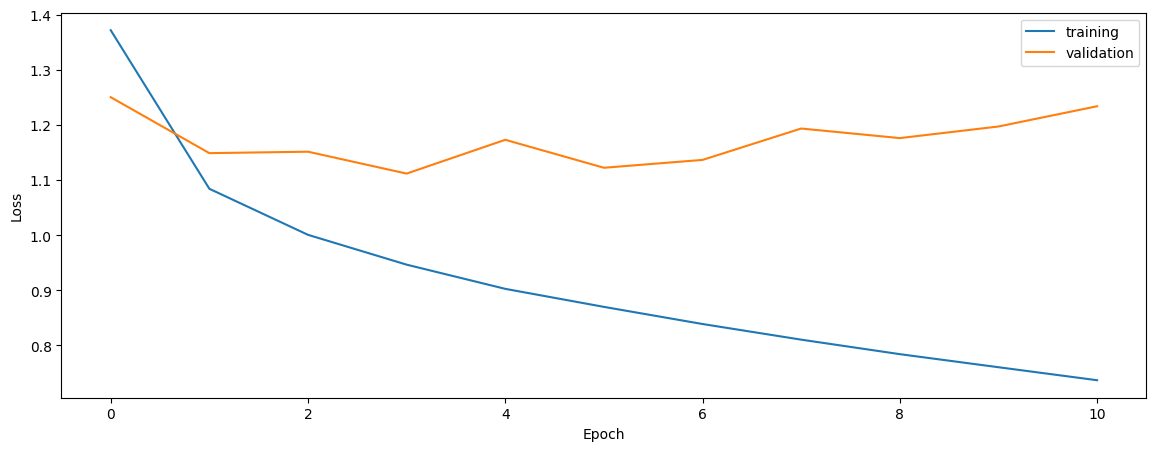

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6457796594940274
0.5474965220527618
0.6280564694737112


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5678268479870742
0.5246720922882427
0.5174743143758596


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5668001859623087
0.5361137440758293
0.5176533108953423


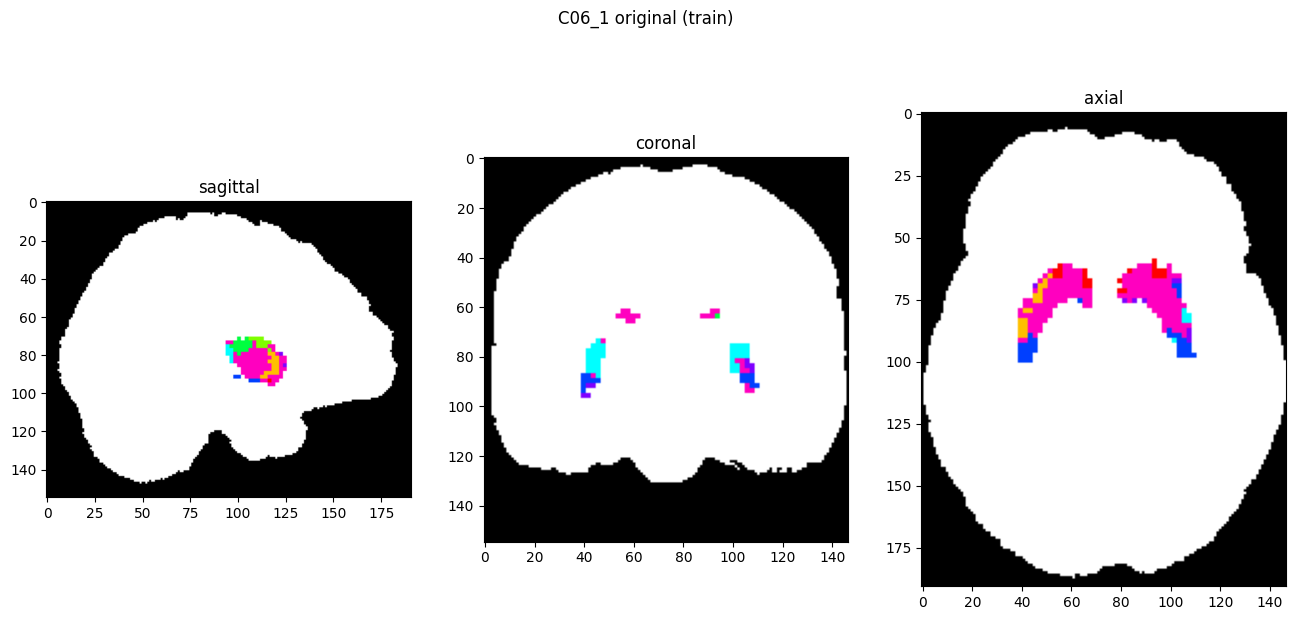

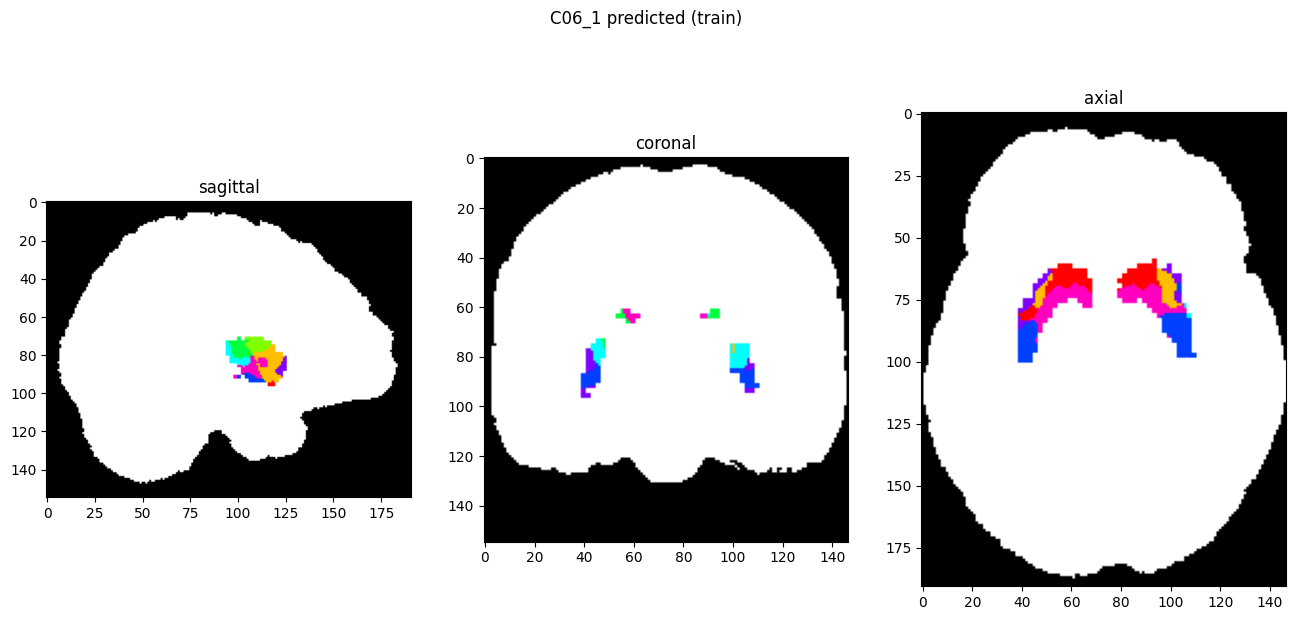

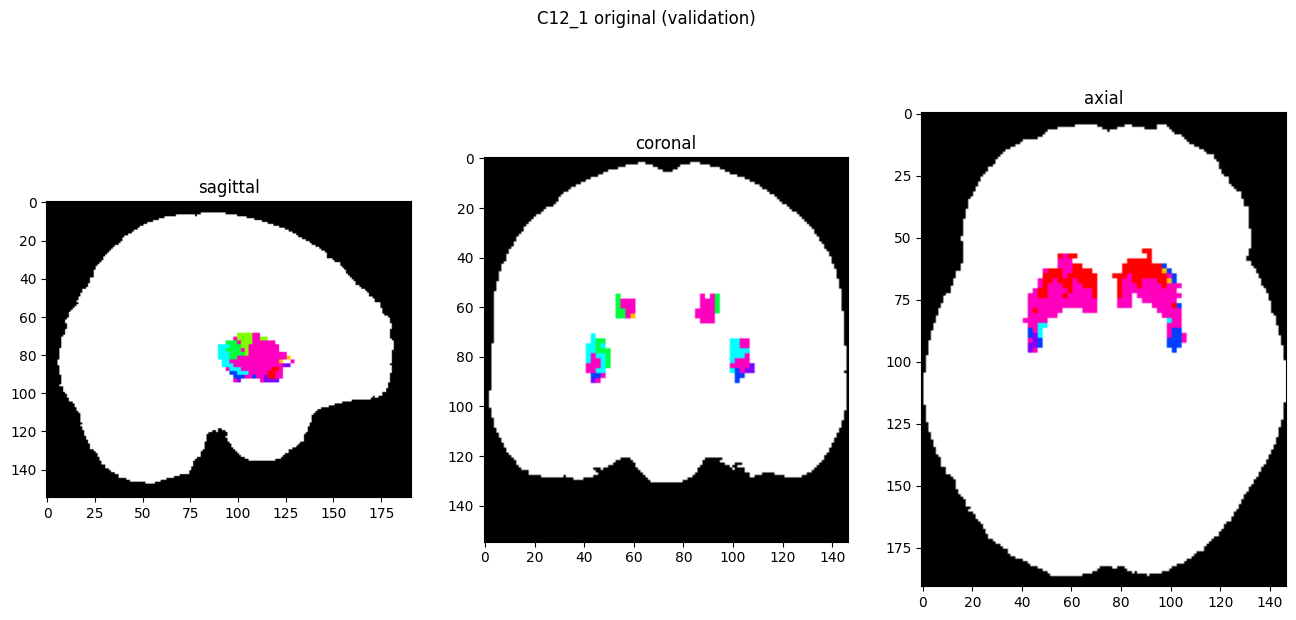

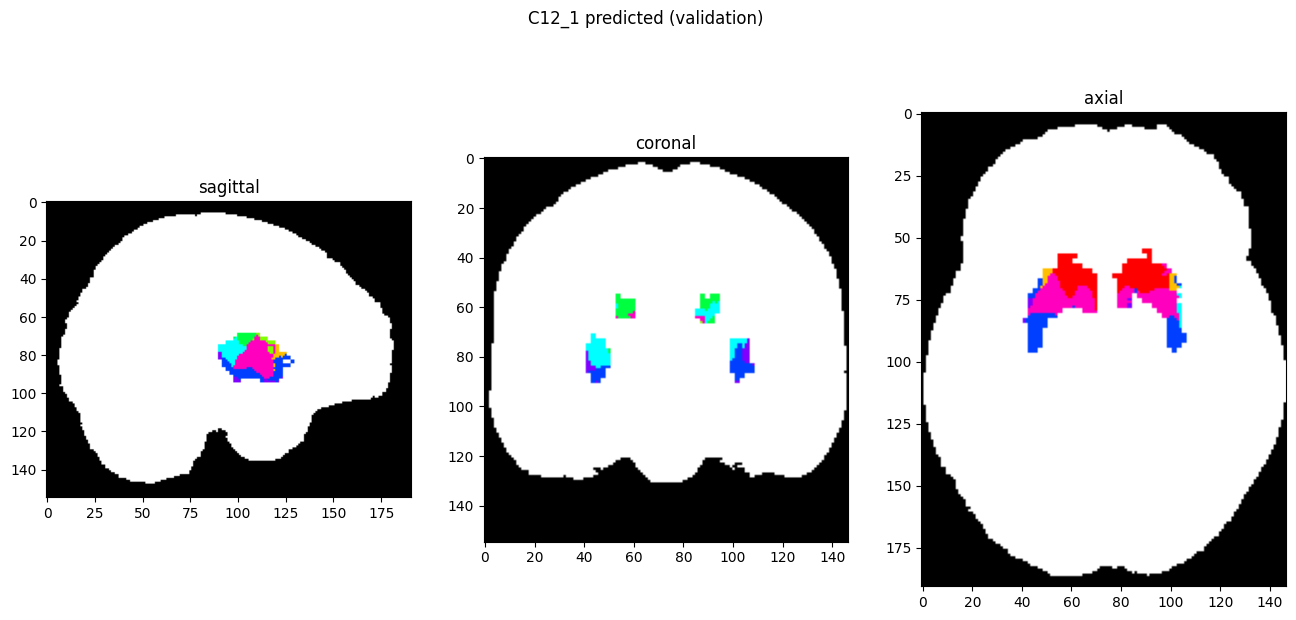

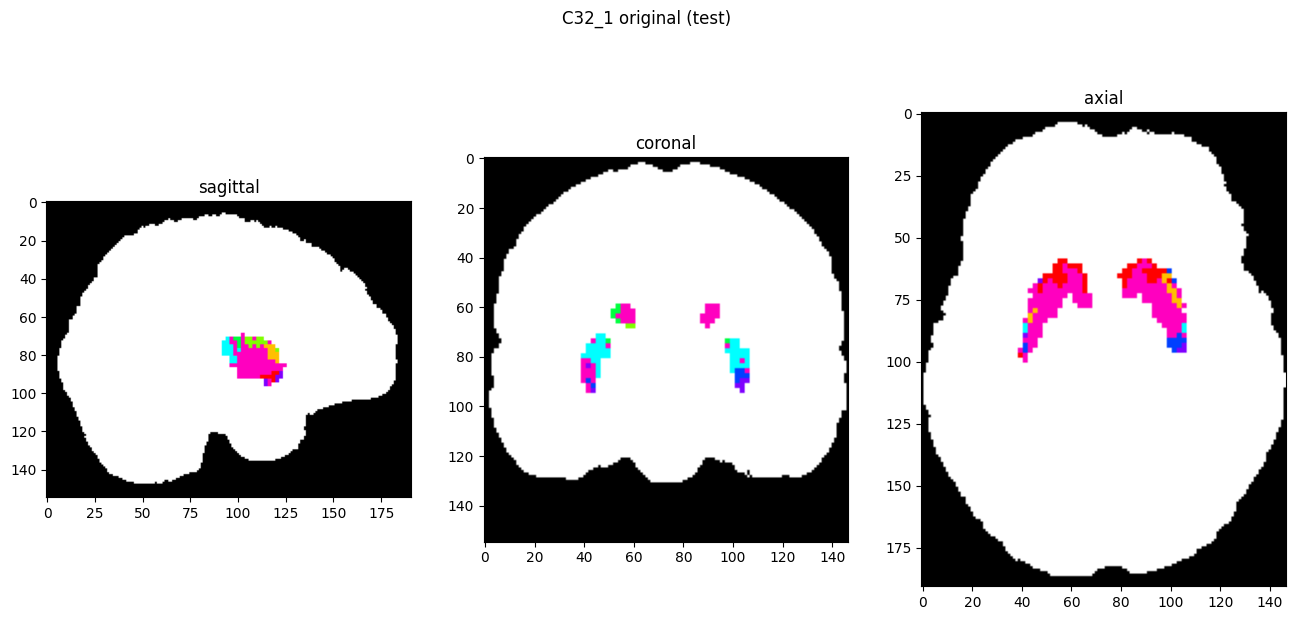

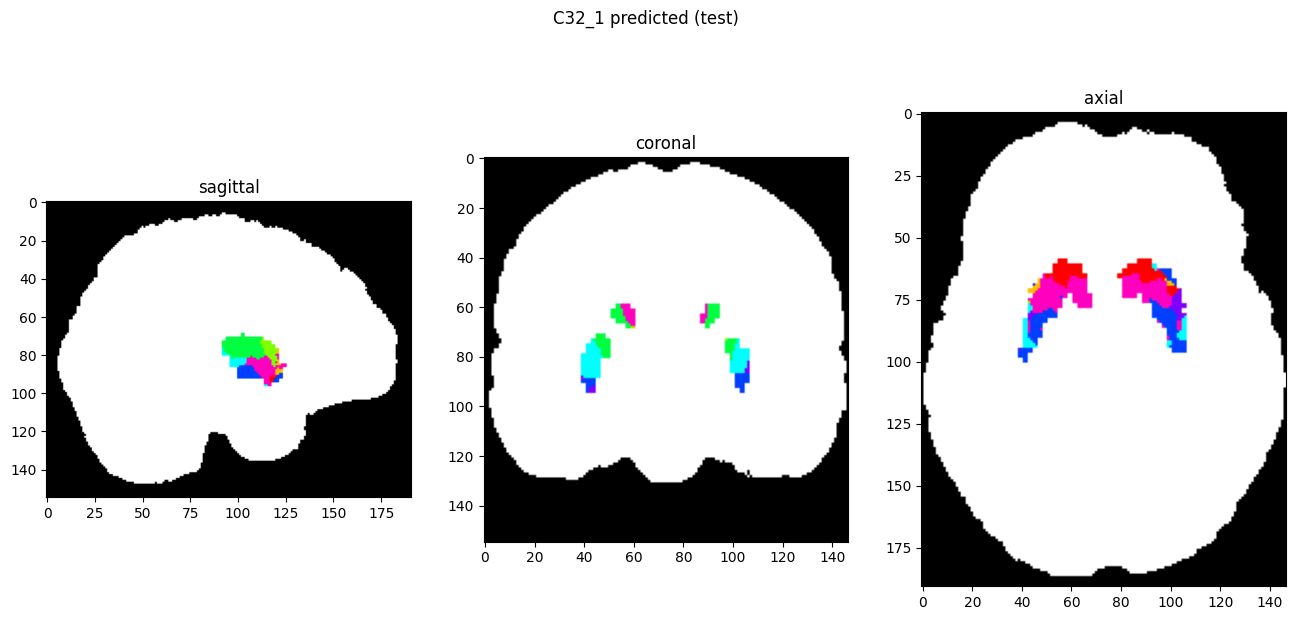

In [10]:
showResults(model, gen, threshold=0)